In [ ]:
!pip install transformers datasets torchtext --quiet

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import random
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

from torch.cuda.amp import autocast, GradScaler

DATA_PATH = '/kaggle/input/gutenberg-poetry-dataset/Gutenberg-Poetry.csv'

df = pd.read_csv(DATA_PATH)

poems = df.groupby('gid')['s'].apply(lambda x: ' '.join(x)).reset_index()

print(f"Total poems: {len(poems)}")
print(poems.head())

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'

warnings.filterwarnings(
    'ignore',
    message=r".*decoder-only architecture.*padding_side='left'.*"
)

class PoetryDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=256):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
        }

train_df, temp_df = train_test_split(poems, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

MAX_LENGTH = 256
MAX_NEW_TOKENS = 50
BATCH_SIZE = 4

train_dataset = PoetryDataset(train_df['s'].tolist(), tokenizer, max_length=MAX_LENGTH)
val_dataset = PoetryDataset(val_df['s'].tolist(), tokenizer, max_length=MAX_LENGTH)
test_dataset = PoetryDataset(test_df['s'].tolist(), tokenizer, max_length=MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class Generator(nn.Module):
    def __init__(self, model_name='gpt2'):
        super(Generator, self).__init__()
        self.model = GPT2LMHeadModel.from_pretrained(model_name)
        self.model.resize_token_embeddings(len(tokenizer))
        
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        return outputs

class Discriminator(nn.Module):
    def __init__(self, model_name='gpt2'):
        super(Discriminator, self).__init__()
        self.transformer = GPT2LMHeadModel.from_pretrained(model_name).transformer
        self.discriminator_head = nn.Sequential(
            nn.Linear(self.transformer.config.n_embd, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 1)
        )
        
    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        last_hidden = hidden_states[:, -1, :]
        logits = self.discriminator_head(last_hidden)
        return logits

generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator_optimizer = AdamW(generator.parameters(), lr=5e-5)
discriminator_optimizer = AdamW(discriminator.parameters(), lr=5e-5)

criterion = nn.BCEWithLogitsLoss()

scaler_gen = GradScaler()
scaler_disc = GradScaler()

def train_generator_mle(generator, dataloader, optimizer, scaler, epoch, print_every=50):
    generator.train()
    total_loss = 0
    for i, batch in enumerate(tqdm(dataloader, desc=f"Generator MLE Training Epoch {epoch}")):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = input_ids.clone()
        with autocast():
            outputs = generator(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
        
        if (i + 1) % print_every == 0:
            avg_loss = total_loss / (i + 1)
            print(f"Epoch {epoch} - Iteration {i+1} - Generator MLE Loss: {avg_loss:.4f}")
    
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch} - Generator MLE Loss: {avg_loss:.4f}")
    return avg_loss

def generate_fake_data(generator, num_samples, max_length, batch_size):
    generator.eval()
    fake_texts = []
    with torch.no_grad():
        for _ in tqdm(range((num_samples + batch_size - 1) // batch_size), desc="Generating Fake Data"):
            input_ids = torch.tensor([[tokenizer.bos_token_id]] * batch_size).to(device)
            attention_mask = torch.ones(input_ids.shape).to(device)
            outputs = generator.model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=max_length,
                num_return_sequences=1,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=1.0,
                pad_token_id=tokenizer.eos_token_id
            )
            texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            fake_texts.extend(texts)
    return fake_texts[:num_samples]

def prepare_fake_loader(generator, num_samples, max_length, batch_size):
    fake_texts = generate_fake_data(generator, num_samples, max_length, batch_size)
    fake_dataset = PoetryDataset(fake_texts, tokenizer, max_length=max_length)
    fake_loader = DataLoader(fake_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    return fake_loader

def train_discriminator(discriminator, real_loader, fake_loader, optimizer, scaler, epoch, print_every=50):
    discriminator.train()
    total_loss = 0
    for i, (real_batch, fake_batch) in enumerate(zip(real_loader, fake_loader)):
        optimizer.zero_grad()
        
        real_input_ids = real_batch['input_ids'].to(device, non_blocking=True)
        real_attention_mask = real_batch['attention_mask'].to(device, non_blocking=True)
        real_labels = torch.ones((real_input_ids.size(0), 1)).to(device)
        with autocast():
            real_logits = discriminator(real_input_ids, real_attention_mask)
            real_loss = criterion(real_logits, real_labels)
        
        fake_input_ids = fake_batch['input_ids'].to(device, non_blocking=True)
        fake_attention_mask = fake_batch['attention_mask'].to(device, non_blocking=True)
        fake_labels = torch.zeros((fake_input_ids.size(0), 1)).to(device)
        with autocast():
            fake_logits = discriminator(fake_input_ids, fake_attention_mask)
            fake_loss = criterion(fake_logits, fake_labels)
        
        loss = real_loss + fake_loss
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
        
        if (i + 1) % print_every == 0:
            avg_loss = total_loss / (i + 1)
            print(f"Epoch {epoch} - Iteration {i+1} - Discriminator Loss: {avg_loss:.4f}")
    
    avg_loss = total_loss / len(real_loader)
    print(f"Epoch {epoch} - Discriminator Loss: {avg_loss:.4f}")
    return avg_loss

def generator_adversarial_loss(generator, discriminator, batch, optimizer, scaler):
    generator.train()
    discriminator.eval()
    
    input_ids = batch['input_ids'].to(device, non_blocking=True)
    attention_mask = batch['attention_mask'].to(device, non_blocking=True)
    
    with autocast():
        outputs = generator.model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=MAX_NEW_TOKENS,
            num_return_sequences=1,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=1.0,
            pad_token_id=tokenizer.eos_token_id
        )
        fake_input_ids = outputs
        fake_attention_mask = (fake_input_ids != tokenizer.pad_token_id).long()
        
        scores = discriminator(fake_input_ids, fake_attention_mask)
        
        labels = torch.ones_like(scores).to(device)
        loss = criterion(scores, labels)
    
    scaler.scale(loss).backward()
    scaler.unscale_(optimizer)
    torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
    scaler.step(optimizer)
    scaler.update()
    
    return loss.item()

def calculate_perplexity(model, dataloader):
    model.eval()
    total_loss = 0
    total_tokens = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Calculating Perplexity"):
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            labels = input_ids.clone()
            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
            total_loss += loss.item() * input_ids.size(0)
            total_tokens += input_ids.size(0)
    avg_loss = total_loss / total_tokens
    perplexity = np.exp(avg_loss)
    return perplexity

def generate_sample_poems(generator, num_samples=5, max_length=100):
    generator.eval()
    sample_texts = []
    with torch.no_grad():
        for _ in range(num_samples):
            input_ids = torch.tensor([[tokenizer.bos_token_id]]).to(device)
            attention_mask = torch.ones(input_ids.shape).to(device)
            output = generator.model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=max_length,
                num_return_sequences=1,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=1.0,
                pad_token_id=tokenizer.eos_token_id
            )
            text = tokenizer.decode(output[0], skip_special_tokens=True)
            sample_texts.append(text)
    for i, poem in enumerate(sample_texts, 1):
        print(f"--- Sample Poem {i} ---\n{poem}\n")

EPOCHS_MLE = 15

for epoch in range(1, EPOCHS_MLE + 1):
    loss = train_generator_mle(generator, train_loader, generator_optimizer, scaler_gen, epoch)
    torch.cuda.empty_cache()

EPOCHS_GAN = 40

for epoch in range(1, EPOCHS_GAN + 1):
    print(f"\n=== GAN Training Epoch {epoch} ===")
    
    fake_loader = prepare_fake_loader(generator, len(train_loader.dataset), MAX_NEW_TOKENS, BATCH_SIZE)
    train_discriminator(discriminator, train_loader, fake_loader, discriminator_optimizer, scaler_disc, epoch)
    torch.cuda.empty_cache()
    
    generator_loss = 0
    generator.train()
    for i, batch in enumerate(tqdm(train_loader, desc=f"Generator GAN Training Epoch {epoch}")):
        loss = generator_adversarial_loss(generator, discriminator, batch, generator_optimizer, scaler_gen)
        generator_loss += loss
        
        if (i + 1) % 50 == 0:
            avg_gen_loss = generator_loss / (i + 1)
            print(f"Epoch {epoch} - Iteration {i+1} - Generator GAN Loss: {avg_gen_loss:.4f}")
    
    avg_gen_loss = generator_loss / len(train_loader)
    print(f"Epoch {epoch} - Generator GAN Loss: {avg_gen_loss:.4f}")
    torch.cuda.empty_cache()

test_perplexity = calculate_perplexity(generator.model, test_loader)
print(f"\nTest Perplexity: {test_perplexity:.2f}")

print("\n=== Generated Sample Poems ===")
generate_sample_poems(generator, num_samples=5, max_length=100)

os.makedirs('saved_models', exist_ok=True)

generator.model.save_pretrained('saved_models/generator')
tokenizer.save_pretrained('saved_models/generator')

torch.save(discriminator.state_dict(), 'saved_models/discriminator.pth')

print("\nModels saved successfully.")


Total poems: 1191
   gid                                                  s
0   19  The Song of Hiawatha is based on the legends a...
1   20  Of that Forbidden Tree, whose mortal tast Brou...
2   26  Of Man's first disobedience, and the fruit Of ...
3   58  I, WHO erewhile the happy Garden sung By one m...
4  109  All I could see from where I stood The room is...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Train size: 952, Validation size: 119, Test size: 120
Using device: cuda


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Generator MLE Training Epoch 1:  21%|██        | 50/238 [00:33<01:35,  1.97it/s]

Epoch 1 - Iteration 50 - Generator MLE Loss: 4.7230


Generator MLE Training Epoch 1:  42%|████▏     | 100/238 [01:11<01:43,  1.33it/s]

Epoch 1 - Iteration 100 - Generator MLE Loss: 4.6793


Generator MLE Training Epoch 1:  63%|██████▎   | 150/238 [01:41<00:52,  1.67it/s]

Epoch 1 - Iteration 150 - Generator MLE Loss: 4.6828


Generator MLE Training Epoch 1:  84%|████████▍ | 200/238 [02:14<00:21,  1.77it/s]

Epoch 1 - Iteration 200 - Generator MLE Loss: 4.6608


Generator MLE Training Epoch 1: 100%|██████████| 238/238 [02:32<00:00,  1.56it/s]


Epoch 1 - Generator MLE Loss: 4.6376


Generator MLE Training Epoch 2:  21%|██        | 50/238 [00:27<01:08,  2.73it/s]

Epoch 2 - Iteration 50 - Generator MLE Loss: 4.3031


Generator MLE Training Epoch 2:  42%|████▏     | 100/238 [00:59<01:17,  1.77it/s]

Epoch 2 - Iteration 100 - Generator MLE Loss: 4.3232


Generator MLE Training Epoch 2:  63%|██████▎   | 150/238 [01:25<00:52,  1.68it/s]

Epoch 2 - Iteration 150 - Generator MLE Loss: 4.3541


Generator MLE Training Epoch 2:  84%|████████▍ | 200/238 [01:57<00:24,  1.56it/s]

Epoch 2 - Iteration 200 - Generator MLE Loss: 4.3649


Generator MLE Training Epoch 2: 100%|██████████| 238/238 [02:21<00:00,  1.69it/s]


Epoch 2 - Generator MLE Loss: 4.3441


Generator MLE Training Epoch 3:  21%|██        | 50/238 [00:29<01:53,  1.66it/s]

Epoch 3 - Iteration 50 - Generator MLE Loss: 4.2047


Generator MLE Training Epoch 3:  42%|████▏     | 100/238 [00:56<01:16,  1.81it/s]

Epoch 3 - Iteration 100 - Generator MLE Loss: 4.1784


Generator MLE Training Epoch 3:  63%|██████▎   | 150/238 [01:27<00:59,  1.47it/s]

Epoch 3 - Iteration 150 - Generator MLE Loss: 4.1611


Generator MLE Training Epoch 3:  84%|████████▍ | 200/238 [01:57<00:26,  1.46it/s]

Epoch 3 - Iteration 200 - Generator MLE Loss: 4.1632


Generator MLE Training Epoch 3: 100%|██████████| 238/238 [02:21<00:00,  1.68it/s]


Epoch 3 - Generator MLE Loss: 4.1624


Generator MLE Training Epoch 4:  21%|██        | 50/238 [00:27<01:51,  1.69it/s]

Epoch 4 - Iteration 50 - Generator MLE Loss: 3.9265


Generator MLE Training Epoch 4:  42%|████▏     | 100/238 [00:55<01:49,  1.26it/s]

Epoch 4 - Iteration 100 - Generator MLE Loss: 3.9387


Generator MLE Training Epoch 4:  63%|██████▎   | 150/238 [01:25<00:38,  2.30it/s]

Epoch 4 - Iteration 150 - Generator MLE Loss: 3.9763


Generator MLE Training Epoch 4:  84%|████████▍ | 200/238 [01:57<00:31,  1.22it/s]

Epoch 4 - Iteration 200 - Generator MLE Loss: 3.9914


Generator MLE Training Epoch 4: 100%|██████████| 238/238 [02:20<00:00,  1.69it/s]


Epoch 4 - Generator MLE Loss: 3.9985


Generator MLE Training Epoch 5:  21%|██        | 50/238 [00:33<02:13,  1.41it/s]

Epoch 5 - Iteration 50 - Generator MLE Loss: 3.7608


Generator MLE Training Epoch 5:  42%|████▏     | 100/238 [01:01<02:00,  1.14it/s]

Epoch 5 - Iteration 100 - Generator MLE Loss: 3.8250


Generator MLE Training Epoch 5:  63%|██████▎   | 150/238 [01:28<00:39,  2.21it/s]

Epoch 5 - Iteration 150 - Generator MLE Loss: 3.8399


Generator MLE Training Epoch 5:  84%|████████▍ | 200/238 [01:58<00:29,  1.28it/s]

Epoch 5 - Iteration 200 - Generator MLE Loss: 3.8455


Generator MLE Training Epoch 5: 100%|██████████| 238/238 [02:20<00:00,  1.69it/s]


Epoch 5 - Generator MLE Loss: 3.8449


Generator MLE Training Epoch 6:  21%|██        | 50/238 [00:29<01:50,  1.71it/s]

Epoch 6 - Iteration 50 - Generator MLE Loss: 3.7500


Generator MLE Training Epoch 6:  42%|████▏     | 100/238 [00:59<01:47,  1.29it/s]

Epoch 6 - Iteration 100 - Generator MLE Loss: 3.6956


Generator MLE Training Epoch 6:  63%|██████▎   | 150/238 [01:31<00:50,  1.73it/s]

Epoch 6 - Iteration 150 - Generator MLE Loss: 3.6749


Generator MLE Training Epoch 6:  84%|████████▍ | 200/238 [01:57<00:20,  1.85it/s]

Epoch 6 - Iteration 200 - Generator MLE Loss: 3.6755


Generator MLE Training Epoch 6: 100%|██████████| 238/238 [02:21<00:00,  1.68it/s]


Epoch 6 - Generator MLE Loss: 3.6837


Generator MLE Training Epoch 7:  21%|██        | 50/238 [00:27<01:23,  2.24it/s]

Epoch 7 - Iteration 50 - Generator MLE Loss: 3.4734


Generator MLE Training Epoch 7:  42%|████▏     | 100/238 [00:54<00:56,  2.45it/s]

Epoch 7 - Iteration 100 - Generator MLE Loss: 3.4777


Generator MLE Training Epoch 7:  63%|██████▎   | 150/238 [01:25<00:57,  1.54it/s]

Epoch 7 - Iteration 150 - Generator MLE Loss: 3.4868


Generator MLE Training Epoch 7:  84%|████████▍ | 200/238 [01:55<00:19,  1.95it/s]

Epoch 7 - Iteration 200 - Generator MLE Loss: 3.5071


Generator MLE Training Epoch 7: 100%|██████████| 238/238 [02:21<00:00,  1.69it/s]


Epoch 7 - Generator MLE Loss: 3.5223


Generator MLE Training Epoch 8:  21%|██        | 50/238 [00:29<01:47,  1.74it/s]

Epoch 8 - Iteration 50 - Generator MLE Loss: 3.4104


Generator MLE Training Epoch 8:  42%|████▏     | 100/238 [01:00<01:46,  1.30it/s]

Epoch 8 - Iteration 100 - Generator MLE Loss: 3.3545


Generator MLE Training Epoch 8:  63%|██████▎   | 150/238 [01:32<00:52,  1.69it/s]

Epoch 8 - Iteration 150 - Generator MLE Loss: 3.3277


Generator MLE Training Epoch 8:  84%|████████▍ | 200/238 [01:58<00:22,  1.67it/s]

Epoch 8 - Iteration 200 - Generator MLE Loss: 3.3579


Generator MLE Training Epoch 8: 100%|██████████| 238/238 [02:20<00:00,  1.69it/s]


Epoch 8 - Generator MLE Loss: 3.3654


Generator MLE Training Epoch 9:  21%|██        | 50/238 [00:30<01:50,  1.70it/s]

Epoch 9 - Iteration 50 - Generator MLE Loss: 3.1140


Generator MLE Training Epoch 9:  42%|████▏     | 100/238 [00:57<01:34,  1.46it/s]

Epoch 9 - Iteration 100 - Generator MLE Loss: 3.1475


Generator MLE Training Epoch 9:  63%|██████▎   | 150/238 [01:26<00:44,  1.98it/s]

Epoch 9 - Iteration 150 - Generator MLE Loss: 3.1726


Generator MLE Training Epoch 9:  84%|████████▍ | 200/238 [01:55<00:21,  1.77it/s]

Epoch 9 - Iteration 200 - Generator MLE Loss: 3.1962


Generator MLE Training Epoch 9: 100%|██████████| 238/238 [02:19<00:00,  1.71it/s]


Epoch 9 - Generator MLE Loss: 3.2115


Generator MLE Training Epoch 10:  21%|██        | 50/238 [00:31<02:21,  1.33it/s]

Epoch 10 - Iteration 50 - Generator MLE Loss: 3.0927


Generator MLE Training Epoch 10:  42%|████▏     | 100/238 [01:02<01:14,  1.86it/s]

Epoch 10 - Iteration 100 - Generator MLE Loss: 3.0582


Generator MLE Training Epoch 10:  63%|██████▎   | 150/238 [01:28<00:57,  1.53it/s]

Epoch 10 - Iteration 150 - Generator MLE Loss: 3.0603


Generator MLE Training Epoch 10:  84%|████████▍ | 200/238 [01:56<00:17,  2.17it/s]

Epoch 10 - Iteration 200 - Generator MLE Loss: 3.0364


Generator MLE Training Epoch 10: 100%|██████████| 238/238 [02:18<00:00,  1.72it/s]


Epoch 10 - Generator MLE Loss: 3.0519


Generator MLE Training Epoch 11:  21%|██        | 50/238 [00:30<01:43,  1.81it/s]

Epoch 11 - Iteration 50 - Generator MLE Loss: 2.7850


Generator MLE Training Epoch 11:  42%|████▏     | 100/238 [01:00<01:42,  1.34it/s]

Epoch 11 - Iteration 100 - Generator MLE Loss: 2.8436


Generator MLE Training Epoch 11:  63%|██████▎   | 150/238 [01:25<00:40,  2.19it/s]

Epoch 11 - Iteration 150 - Generator MLE Loss: 2.8988


Generator MLE Training Epoch 11:  84%|████████▍ | 200/238 [01:55<00:21,  1.74it/s]

Epoch 11 - Iteration 200 - Generator MLE Loss: 2.9053


Generator MLE Training Epoch 11: 100%|██████████| 238/238 [02:18<00:00,  1.72it/s]


Epoch 11 - Generator MLE Loss: 2.9014


Generator MLE Training Epoch 12:  21%|██        | 50/238 [00:28<02:23,  1.31it/s]

Epoch 12 - Iteration 50 - Generator MLE Loss: 2.7305


Generator MLE Training Epoch 12:  42%|████▏     | 100/238 [00:56<01:26,  1.60it/s]

Epoch 12 - Iteration 100 - Generator MLE Loss: 2.7322


Generator MLE Training Epoch 12:  63%|██████▎   | 150/238 [01:26<01:03,  1.38it/s]

Epoch 12 - Iteration 150 - Generator MLE Loss: 2.7445


Generator MLE Training Epoch 12:  84%|████████▍ | 200/238 [01:56<00:21,  1.75it/s]

Epoch 12 - Iteration 200 - Generator MLE Loss: 2.7443


Generator MLE Training Epoch 12: 100%|██████████| 238/238 [02:18<00:00,  1.72it/s]


Epoch 12 - Generator MLE Loss: 2.7529


Generator MLE Training Epoch 13:  21%|██        | 50/238 [00:31<01:50,  1.70it/s]

Epoch 13 - Iteration 50 - Generator MLE Loss: 2.5590


Generator MLE Training Epoch 13:  42%|████▏     | 100/238 [01:02<01:26,  1.59it/s]

Epoch 13 - Iteration 100 - Generator MLE Loss: 2.5899


Generator MLE Training Epoch 13:  63%|██████▎   | 150/238 [01:29<00:49,  1.78it/s]

Epoch 13 - Iteration 150 - Generator MLE Loss: 2.5866


Generator MLE Training Epoch 13:  84%|████████▍ | 200/238 [01:56<00:17,  2.13it/s]

Epoch 13 - Iteration 200 - Generator MLE Loss: 2.5863


Generator MLE Training Epoch 13: 100%|██████████| 238/238 [02:19<00:00,  1.71it/s]


Epoch 13 - Generator MLE Loss: 2.6042


Generator MLE Training Epoch 14:  21%|██        | 50/238 [00:27<01:50,  1.71it/s]

Epoch 14 - Iteration 50 - Generator MLE Loss: 2.4112


Generator MLE Training Epoch 14:  42%|████▏     | 100/238 [00:59<01:16,  1.79it/s]

Epoch 14 - Iteration 100 - Generator MLE Loss: 2.4364


Generator MLE Training Epoch 14:  63%|██████▎   | 150/238 [01:25<01:00,  1.46it/s]

Epoch 14 - Iteration 150 - Generator MLE Loss: 2.4625


Generator MLE Training Epoch 14:  84%|████████▍ | 200/238 [01:56<00:21,  1.73it/s]

Epoch 14 - Iteration 200 - Generator MLE Loss: 2.4623


Generator MLE Training Epoch 14: 100%|██████████| 238/238 [02:18<00:00,  1.72it/s]


Epoch 14 - Generator MLE Loss: 2.4634


Generator MLE Training Epoch 15:  21%|██        | 50/238 [00:30<01:51,  1.69it/s]

Epoch 15 - Iteration 50 - Generator MLE Loss: 2.3080


Generator MLE Training Epoch 15:  42%|████▏     | 100/238 [00:57<01:24,  1.64it/s]

Epoch 15 - Iteration 100 - Generator MLE Loss: 2.3069


Generator MLE Training Epoch 15:  63%|██████▎   | 150/238 [01:24<00:42,  2.07it/s]

Epoch 15 - Iteration 150 - Generator MLE Loss: 2.3130


Generator MLE Training Epoch 15:  84%|████████▍ | 200/238 [01:54<00:26,  1.42it/s]

Epoch 15 - Iteration 200 - Generator MLE Loss: 2.3285


Generator MLE Training Epoch 15: 100%|██████████| 238/238 [02:18<00:00,  1.72it/s]


Epoch 15 - Generator MLE Loss: 2.3324

=== GAN Training Epoch 1 ===


Generating Fake Data: 100%|██████████| 238/238 [02:05<00:00,  1.90it/s]


Epoch 1 - Iteration 50 - Discriminator Loss: 1.5622
Epoch 1 - Iteration 100 - Discriminator Loss: 1.4825
Epoch 1 - Iteration 150 - Discriminator Loss: 1.4100
Epoch 1 - Iteration 200 - Discriminator Loss: 1.3626
Epoch 1 - Discriminator Loss: 1.3261


Generator GAN Training Epoch 1:  21%|██        | 50/238 [00:55<03:54,  1.25s/it]

Epoch 1 - Iteration 50 - Generator GAN Loss: 0.6482


Generator GAN Training Epoch 1:  42%|████▏     | 100/238 [01:50<02:25,  1.06s/it]

Epoch 1 - Iteration 100 - Generator GAN Loss: 0.6400


Generator GAN Training Epoch 1:  63%|██████▎   | 150/238 [02:45<01:25,  1.03it/s]

Epoch 1 - Iteration 150 - Generator GAN Loss: 0.6471


Generator GAN Training Epoch 1:  84%|████████▍ | 200/238 [03:41<00:39,  1.04s/it]

Epoch 1 - Iteration 200 - Generator GAN Loss: 0.6466


Generator GAN Training Epoch 1: 100%|██████████| 238/238 [04:22<00:00,  1.10s/it]


Epoch 1 - Generator GAN Loss: 0.6495

=== GAN Training Epoch 2 ===


Generating Fake Data: 100%|██████████| 238/238 [02:04<00:00,  1.92it/s]


Epoch 2 - Iteration 50 - Discriminator Loss: 1.1065
Epoch 2 - Iteration 100 - Discriminator Loss: 1.1308
Epoch 2 - Iteration 150 - Discriminator Loss: 1.1111
Epoch 2 - Iteration 200 - Discriminator Loss: 1.1066
Epoch 2 - Discriminator Loss: 1.0893


Generator GAN Training Epoch 2:  21%|██        | 50/238 [00:55<02:59,  1.05it/s]

Epoch 2 - Iteration 50 - Generator GAN Loss: 0.6224


Generator GAN Training Epoch 2:  42%|████▏     | 100/238 [01:54<02:42,  1.18s/it]

Epoch 2 - Iteration 100 - Generator GAN Loss: 0.6243


Generator GAN Training Epoch 2:  63%|██████▎   | 150/238 [02:50<01:29,  1.01s/it]

Epoch 2 - Iteration 150 - Generator GAN Loss: 0.6303


Generator GAN Training Epoch 2:  84%|████████▍ | 200/238 [03:43<00:45,  1.19s/it]

Epoch 2 - Iteration 200 - Generator GAN Loss: 0.6320


Generator GAN Training Epoch 2: 100%|██████████| 238/238 [04:23<00:00,  1.11s/it]


Epoch 2 - Generator GAN Loss: 0.6276

=== GAN Training Epoch 3 ===


Generating Fake Data: 100%|██████████| 238/238 [02:03<00:00,  1.92it/s]


Epoch 3 - Iteration 50 - Discriminator Loss: 1.0020
Epoch 3 - Iteration 100 - Discriminator Loss: 1.0133
Epoch 3 - Iteration 150 - Discriminator Loss: 0.9946
Epoch 3 - Iteration 200 - Discriminator Loss: 0.9636
Epoch 3 - Discriminator Loss: 0.9818


Generator GAN Training Epoch 3:  21%|██        | 50/238 [00:55<04:09,  1.33s/it]

Epoch 3 - Iteration 50 - Generator GAN Loss: 0.5199


Generator GAN Training Epoch 3:  42%|████▏     | 100/238 [01:52<03:08,  1.37s/it]

Epoch 3 - Iteration 100 - Generator GAN Loss: 0.5155


Generator GAN Training Epoch 3:  63%|██████▎   | 150/238 [02:50<01:43,  1.18s/it]

Epoch 3 - Iteration 150 - Generator GAN Loss: 0.5055


Generator GAN Training Epoch 3:  84%|████████▍ | 200/238 [03:44<00:43,  1.15s/it]

Epoch 3 - Iteration 200 - Generator GAN Loss: 0.5090


Generator GAN Training Epoch 3: 100%|██████████| 238/238 [04:25<00:00,  1.11s/it]


Epoch 3 - Generator GAN Loss: 0.5034

=== GAN Training Epoch 4 ===


Generating Fake Data: 100%|██████████| 238/238 [02:07<00:00,  1.86it/s]


Epoch 4 - Iteration 50 - Discriminator Loss: 0.7916
Epoch 4 - Iteration 100 - Discriminator Loss: 0.8478
Epoch 4 - Iteration 150 - Discriminator Loss: 0.8409
Epoch 4 - Iteration 200 - Discriminator Loss: 0.8435
Epoch 4 - Discriminator Loss: 0.8357


Generator GAN Training Epoch 4:  21%|██        | 50/238 [00:59<03:33,  1.14s/it]

Epoch 4 - Iteration 50 - Generator GAN Loss: 0.5855


Generator GAN Training Epoch 4:  42%|████▏     | 100/238 [01:59<02:46,  1.21s/it]

Epoch 4 - Iteration 100 - Generator GAN Loss: 0.5792


Generator GAN Training Epoch 4:  63%|██████▎   | 150/238 [02:54<01:29,  1.01s/it]

Epoch 4 - Iteration 150 - Generator GAN Loss: 0.5769


Generator GAN Training Epoch 4:  84%|████████▍ | 200/238 [03:49<00:49,  1.29s/it]

Epoch 4 - Iteration 200 - Generator GAN Loss: 0.5870


Generator GAN Training Epoch 4: 100%|██████████| 238/238 [04:35<00:00,  1.16s/it]


Epoch 4 - Generator GAN Loss: 0.5846

=== GAN Training Epoch 5 ===


Generating Fake Data: 100%|██████████| 238/238 [02:07<00:00,  1.86it/s]


Epoch 5 - Iteration 50 - Discriminator Loss: 0.8598
Epoch 5 - Iteration 100 - Discriminator Loss: 0.8643
Epoch 5 - Iteration 150 - Discriminator Loss: 0.8275
Epoch 5 - Iteration 200 - Discriminator Loss: 0.8314
Epoch 5 - Discriminator Loss: 0.8143


Generator GAN Training Epoch 5:  21%|██        | 50/238 [00:59<03:28,  1.11s/it]

Epoch 5 - Iteration 50 - Generator GAN Loss: 0.5781


Generator GAN Training Epoch 5:  42%|████▏     | 100/238 [01:56<02:27,  1.07s/it]

Epoch 5 - Iteration 100 - Generator GAN Loss: 0.5593


Generator GAN Training Epoch 5:  63%|██████▎   | 150/238 [02:55<01:26,  1.02it/s]

Epoch 5 - Iteration 150 - Generator GAN Loss: 0.5563


Generator GAN Training Epoch 5:  84%|████████▍ | 200/238 [03:53<00:46,  1.22s/it]

Epoch 5 - Iteration 200 - Generator GAN Loss: 0.5537


Generator GAN Training Epoch 5: 100%|██████████| 238/238 [04:33<00:00,  1.15s/it]


Epoch 5 - Generator GAN Loss: 0.5631

=== GAN Training Epoch 6 ===


Generating Fake Data: 100%|██████████| 238/238 [02:07<00:00,  1.87it/s]


Epoch 6 - Iteration 50 - Discriminator Loss: 0.7724
Epoch 6 - Iteration 100 - Discriminator Loss: 0.7463
Epoch 6 - Iteration 150 - Discriminator Loss: 0.7502
Epoch 6 - Iteration 200 - Discriminator Loss: 0.7404
Epoch 6 - Discriminator Loss: 0.7393


Generator GAN Training Epoch 6:  21%|██        | 50/238 [00:57<03:27,  1.10s/it]

Epoch 6 - Iteration 50 - Generator GAN Loss: 0.3835


Generator GAN Training Epoch 6:  42%|████▏     | 100/238 [01:55<02:39,  1.16s/it]

Epoch 6 - Iteration 100 - Generator GAN Loss: 0.3899


Generator GAN Training Epoch 6:  63%|██████▎   | 150/238 [02:52<02:07,  1.45s/it]

Epoch 6 - Iteration 150 - Generator GAN Loss: 0.3815


Generator GAN Training Epoch 6:  84%|████████▍ | 200/238 [03:51<00:38,  1.01s/it]

Epoch 6 - Iteration 200 - Generator GAN Loss: 0.3880


Generator GAN Training Epoch 6: 100%|██████████| 238/238 [04:32<00:00,  1.15s/it]


Epoch 6 - Generator GAN Loss: 0.3862

=== GAN Training Epoch 7 ===


Generating Fake Data: 100%|██████████| 238/238 [02:08<00:00,  1.85it/s]


Epoch 7 - Iteration 50 - Discriminator Loss: 0.7024
Epoch 7 - Iteration 100 - Discriminator Loss: 0.6929
Epoch 7 - Iteration 150 - Discriminator Loss: 0.7099
Epoch 7 - Iteration 200 - Discriminator Loss: 0.7030
Epoch 7 - Discriminator Loss: 0.6826


Generator GAN Training Epoch 7:  21%|██        | 50/238 [00:57<03:06,  1.01it/s]

Epoch 7 - Iteration 50 - Generator GAN Loss: 0.7259


Generator GAN Training Epoch 7:  42%|████▏     | 100/238 [01:52<02:33,  1.11s/it]

Epoch 7 - Iteration 100 - Generator GAN Loss: 0.6904


Generator GAN Training Epoch 7:  63%|██████▎   | 150/238 [02:49<01:34,  1.08s/it]

Epoch 7 - Iteration 150 - Generator GAN Loss: 0.6789


Generator GAN Training Epoch 7:  84%|████████▍ | 200/238 [03:44<00:44,  1.18s/it]

Epoch 7 - Iteration 200 - Generator GAN Loss: 0.6722


Generator GAN Training Epoch 7: 100%|██████████| 238/238 [04:33<00:00,  1.15s/it]


Epoch 7 - Generator GAN Loss: 0.6710

=== GAN Training Epoch 8 ===


Generating Fake Data: 100%|██████████| 238/238 [02:08<00:00,  1.86it/s]


Epoch 8 - Iteration 50 - Discriminator Loss: 0.6206
Epoch 8 - Iteration 100 - Discriminator Loss: 0.6636
Epoch 8 - Iteration 150 - Discriminator Loss: 0.6364
Epoch 8 - Iteration 200 - Discriminator Loss: 0.6322
Epoch 8 - Discriminator Loss: 0.6276


Generator GAN Training Epoch 8:  21%|██        | 50/238 [00:54<03:02,  1.03it/s]

Epoch 8 - Iteration 50 - Generator GAN Loss: 0.5836


Generator GAN Training Epoch 8:  42%|████▏     | 100/238 [01:49<02:31,  1.10s/it]

Epoch 8 - Iteration 100 - Generator GAN Loss: 0.5546


Generator GAN Training Epoch 8:  63%|██████▎   | 150/238 [02:43<01:29,  1.02s/it]

Epoch 8 - Iteration 150 - Generator GAN Loss: 0.5517


Generator GAN Training Epoch 8:  84%|████████▍ | 200/238 [03:45<00:54,  1.42s/it]

Epoch 8 - Iteration 200 - Generator GAN Loss: 0.5375


Generator GAN Training Epoch 8: 100%|██████████| 238/238 [04:32<00:00,  1.15s/it]


Epoch 8 - Generator GAN Loss: 0.5456

=== GAN Training Epoch 9 ===


Generating Fake Data: 100%|██████████| 238/238 [02:08<00:00,  1.85it/s]


Epoch 9 - Iteration 50 - Discriminator Loss: 0.6711
Epoch 9 - Iteration 100 - Discriminator Loss: 0.6268
Epoch 9 - Iteration 150 - Discriminator Loss: 0.6298
Epoch 9 - Iteration 200 - Discriminator Loss: 0.6143
Epoch 9 - Discriminator Loss: 0.6040


Generator GAN Training Epoch 9:  21%|██        | 50/238 [00:58<02:55,  1.07it/s]

Epoch 9 - Iteration 50 - Generator GAN Loss: 0.6399


Generator GAN Training Epoch 9:  42%|████▏     | 100/238 [01:56<02:32,  1.11s/it]

Epoch 9 - Iteration 100 - Generator GAN Loss: 0.6273


Generator GAN Training Epoch 9:  63%|██████▎   | 150/238 [02:55<01:46,  1.21s/it]

Epoch 9 - Iteration 150 - Generator GAN Loss: 0.6525


Generator GAN Training Epoch 9:  84%|████████▍ | 200/238 [03:52<00:41,  1.10s/it]

Epoch 9 - Iteration 200 - Generator GAN Loss: 0.6417


Generator GAN Training Epoch 9: 100%|██████████| 238/238 [04:33<00:00,  1.15s/it]


Epoch 9 - Generator GAN Loss: 0.6394

=== GAN Training Epoch 10 ===


Generating Fake Data: 100%|██████████| 238/238 [02:08<00:00,  1.85it/s]


Epoch 10 - Iteration 50 - Discriminator Loss: 0.6313
Epoch 10 - Iteration 100 - Discriminator Loss: 0.5791
Epoch 10 - Iteration 150 - Discriminator Loss: 0.5698
Epoch 10 - Iteration 200 - Discriminator Loss: 0.5717
Epoch 10 - Discriminator Loss: 0.5742


Generator GAN Training Epoch 10:  21%|██        | 50/238 [00:54<03:34,  1.14s/it]

Epoch 10 - Iteration 50 - Generator GAN Loss: 0.4236


Generator GAN Training Epoch 10:  42%|████▏     | 100/238 [01:56<03:22,  1.47s/it]

Epoch 10 - Iteration 100 - Generator GAN Loss: 0.4253


Generator GAN Training Epoch 10:  63%|██████▎   | 150/238 [02:54<01:44,  1.19s/it]

Epoch 10 - Iteration 150 - Generator GAN Loss: 0.4263


Generator GAN Training Epoch 10:  84%|████████▍ | 200/238 [03:53<00:38,  1.01s/it]

Epoch 10 - Iteration 200 - Generator GAN Loss: 0.4220


Generator GAN Training Epoch 10: 100%|██████████| 238/238 [04:32<00:00,  1.14s/it]


Epoch 10 - Generator GAN Loss: 0.4111

=== GAN Training Epoch 11 ===


Generating Fake Data: 100%|██████████| 238/238 [02:08<00:00,  1.85it/s]


Epoch 11 - Iteration 50 - Discriminator Loss: 0.6535
Epoch 11 - Iteration 100 - Discriminator Loss: 0.5991
Epoch 11 - Iteration 150 - Discriminator Loss: 0.5771
Epoch 11 - Iteration 200 - Discriminator Loss: 0.5575
Epoch 11 - Discriminator Loss: 0.5424


Generator GAN Training Epoch 11:  21%|██        | 50/238 [00:56<03:14,  1.03s/it]

Epoch 11 - Iteration 50 - Generator GAN Loss: 0.4126


Generator GAN Training Epoch 11:  42%|████▏     | 100/238 [01:55<02:16,  1.01it/s]

Epoch 11 - Iteration 100 - Generator GAN Loss: 0.4535


Generator GAN Training Epoch 11:  63%|██████▎   | 150/238 [02:52<01:29,  1.02s/it]

Epoch 11 - Iteration 150 - Generator GAN Loss: 0.4479


Generator GAN Training Epoch 11:  84%|████████▍ | 200/238 [03:53<00:37,  1.02it/s]

Epoch 11 - Iteration 200 - Generator GAN Loss: 0.4505


Generator GAN Training Epoch 11: 100%|██████████| 238/238 [04:33<00:00,  1.15s/it]


Epoch 11 - Generator GAN Loss: 0.4520

=== GAN Training Epoch 12 ===


Generating Fake Data: 100%|██████████| 238/238 [02:07<00:00,  1.86it/s]


Epoch 12 - Iteration 50 - Discriminator Loss: 0.5531
Epoch 12 - Iteration 100 - Discriminator Loss: 0.5323
Epoch 12 - Iteration 150 - Discriminator Loss: 0.5083
Epoch 12 - Iteration 200 - Discriminator Loss: 0.5132
Epoch 12 - Discriminator Loss: 0.5123


Generator GAN Training Epoch 12:  21%|██        | 50/238 [00:59<03:44,  1.19s/it]

Epoch 12 - Iteration 50 - Generator GAN Loss: 0.5901


Generator GAN Training Epoch 12:  42%|████▏     | 100/238 [01:54<02:45,  1.20s/it]

Epoch 12 - Iteration 100 - Generator GAN Loss: 0.5634


Generator GAN Training Epoch 12:  63%|██████▎   | 150/238 [02:50<01:56,  1.32s/it]

Epoch 12 - Iteration 150 - Generator GAN Loss: 0.5493


Generator GAN Training Epoch 12:  84%|████████▍ | 200/238 [03:47<00:38,  1.02s/it]

Epoch 12 - Iteration 200 - Generator GAN Loss: 0.5497


Generator GAN Training Epoch 12: 100%|██████████| 238/238 [04:32<00:00,  1.15s/it]


Epoch 12 - Generator GAN Loss: 0.5535

=== GAN Training Epoch 13 ===


Generating Fake Data: 100%|██████████| 238/238 [02:08<00:00,  1.86it/s]


Epoch 13 - Iteration 50 - Discriminator Loss: 0.5019
Epoch 13 - Iteration 100 - Discriminator Loss: 0.5450
Epoch 13 - Iteration 150 - Discriminator Loss: 0.5018
Epoch 13 - Iteration 200 - Discriminator Loss: 0.5161
Epoch 13 - Discriminator Loss: 0.5123


Generator GAN Training Epoch 13:  21%|██        | 50/238 [01:00<03:23,  1.08s/it]

Epoch 13 - Iteration 50 - Generator GAN Loss: 0.4141


Generator GAN Training Epoch 13:  42%|████▏     | 100/238 [01:57<02:44,  1.19s/it]

Epoch 13 - Iteration 100 - Generator GAN Loss: 0.4001


Generator GAN Training Epoch 13:  63%|██████▎   | 150/238 [02:53<01:43,  1.18s/it]

Epoch 13 - Iteration 150 - Generator GAN Loss: 0.4389


Generator GAN Training Epoch 13:  84%|████████▍ | 200/238 [03:52<00:45,  1.19s/it]

Epoch 13 - Iteration 200 - Generator GAN Loss: 0.4428


Generator GAN Training Epoch 13: 100%|██████████| 238/238 [04:32<00:00,  1.14s/it]


Epoch 13 - Generator GAN Loss: 0.4221

=== GAN Training Epoch 14 ===


Generating Fake Data: 100%|██████████| 238/238 [02:08<00:00,  1.86it/s]


Epoch 14 - Iteration 50 - Discriminator Loss: 0.4763
Epoch 14 - Iteration 100 - Discriminator Loss: 0.5008
Epoch 14 - Iteration 150 - Discriminator Loss: 0.5070
Epoch 14 - Iteration 200 - Discriminator Loss: 0.5211
Epoch 14 - Discriminator Loss: 0.5279


Generator GAN Training Epoch 14:  21%|██        | 50/238 [00:58<03:49,  1.22s/it]

Epoch 14 - Iteration 50 - Generator GAN Loss: 0.5167


Generator GAN Training Epoch 14:  42%|████▏     | 100/238 [01:53<02:06,  1.09it/s]

Epoch 14 - Iteration 100 - Generator GAN Loss: 0.5704


Generator GAN Training Epoch 14:  63%|██████▎   | 150/238 [02:51<01:33,  1.06s/it]

Epoch 14 - Iteration 150 - Generator GAN Loss: 0.5857


Generator GAN Training Epoch 14:  84%|████████▍ | 200/238 [03:51<00:52,  1.38s/it]

Epoch 14 - Iteration 200 - Generator GAN Loss: 0.6460


Generator GAN Training Epoch 14: 100%|██████████| 238/238 [04:32<00:00,  1.15s/it]


Epoch 14 - Generator GAN Loss: 0.6364

=== GAN Training Epoch 15 ===


Generating Fake Data: 100%|██████████| 238/238 [02:09<00:00,  1.84it/s]


Epoch 15 - Iteration 50 - Discriminator Loss: 0.4896
Epoch 15 - Iteration 100 - Discriminator Loss: 0.4711
Epoch 15 - Iteration 150 - Discriminator Loss: 0.4738
Epoch 15 - Iteration 200 - Discriminator Loss: 0.4876
Epoch 15 - Discriminator Loss: 0.4963


Generator GAN Training Epoch 15:  21%|██        | 50/238 [00:56<03:18,  1.06s/it]

Epoch 15 - Iteration 50 - Generator GAN Loss: 0.5781


Generator GAN Training Epoch 15:  42%|████▏     | 100/238 [01:58<02:38,  1.15s/it]

Epoch 15 - Iteration 100 - Generator GAN Loss: 0.5595


Generator GAN Training Epoch 15:  63%|██████▎   | 150/238 [02:58<01:57,  1.33s/it]

Epoch 15 - Iteration 150 - Generator GAN Loss: 0.5801


Generator GAN Training Epoch 15:  84%|████████▍ | 200/238 [03:53<00:46,  1.23s/it]

Epoch 15 - Iteration 200 - Generator GAN Loss: 0.5783


Generator GAN Training Epoch 15: 100%|██████████| 238/238 [04:34<00:00,  1.15s/it]


Epoch 15 - Generator GAN Loss: 0.5911

=== GAN Training Epoch 16 ===


Generating Fake Data: 100%|██████████| 238/238 [02:08<00:00,  1.85it/s]


Epoch 16 - Iteration 50 - Discriminator Loss: 0.5083
Epoch 16 - Iteration 100 - Discriminator Loss: 0.4904
Epoch 16 - Iteration 150 - Discriminator Loss: 0.4903
Epoch 16 - Iteration 200 - Discriminator Loss: 0.4909
Epoch 16 - Discriminator Loss: 0.4979


Generator GAN Training Epoch 16:  21%|██        | 50/238 [00:56<03:35,  1.15s/it]

Epoch 16 - Iteration 50 - Generator GAN Loss: 0.4955


Generator GAN Training Epoch 16:  42%|████▏     | 100/238 [01:54<02:17,  1.00it/s]

Epoch 16 - Iteration 100 - Generator GAN Loss: 0.5204


Generator GAN Training Epoch 16:  63%|██████▎   | 150/238 [02:51<01:43,  1.18s/it]

Epoch 16 - Iteration 150 - Generator GAN Loss: 0.5485


Generator GAN Training Epoch 16:  84%|████████▍ | 200/238 [03:46<00:42,  1.11s/it]

Epoch 16 - Iteration 200 - Generator GAN Loss: 0.5315


Generator GAN Training Epoch 16: 100%|██████████| 238/238 [04:32<00:00,  1.15s/it]


Epoch 16 - Generator GAN Loss: 0.5318

=== GAN Training Epoch 17 ===


Generating Fake Data: 100%|██████████| 238/238 [02:08<00:00,  1.85it/s]


Epoch 17 - Iteration 50 - Discriminator Loss: 0.4183
Epoch 17 - Iteration 100 - Discriminator Loss: 0.4472
Epoch 17 - Iteration 150 - Discriminator Loss: 0.4646
Epoch 17 - Iteration 200 - Discriminator Loss: 0.4791
Epoch 17 - Discriminator Loss: 0.4996


Generator GAN Training Epoch 17:  21%|██        | 50/238 [00:57<03:32,  1.13s/it]

Epoch 17 - Iteration 50 - Generator GAN Loss: 0.6858


Generator GAN Training Epoch 17:  42%|████▏     | 100/238 [01:57<02:25,  1.05s/it]

Epoch 17 - Iteration 100 - Generator GAN Loss: 0.7088


Generator GAN Training Epoch 17:  63%|██████▎   | 150/238 [02:49<01:25,  1.03it/s]

Epoch 17 - Iteration 150 - Generator GAN Loss: 0.6699


Generator GAN Training Epoch 17:  84%|████████▍ | 200/238 [03:44<00:40,  1.06s/it]

Epoch 17 - Iteration 200 - Generator GAN Loss: 0.6575


Generator GAN Training Epoch 17: 100%|██████████| 238/238 [04:32<00:00,  1.15s/it]


Epoch 17 - Generator GAN Loss: 0.6307

=== GAN Training Epoch 18 ===


Generating Fake Data: 100%|██████████| 238/238 [02:08<00:00,  1.85it/s]


Epoch 18 - Iteration 50 - Discriminator Loss: 0.4480
Epoch 18 - Iteration 100 - Discriminator Loss: 0.4693
Epoch 18 - Iteration 150 - Discriminator Loss: 0.4710
Epoch 18 - Iteration 200 - Discriminator Loss: 0.4528
Epoch 18 - Discriminator Loss: 0.4549


Generator GAN Training Epoch 18:  21%|██        | 50/238 [01:01<03:18,  1.06s/it]

Epoch 18 - Iteration 50 - Generator GAN Loss: 0.5723


Generator GAN Training Epoch 18:  42%|████▏     | 100/238 [02:00<02:37,  1.14s/it]

Epoch 18 - Iteration 100 - Generator GAN Loss: 0.4721


Generator GAN Training Epoch 18:  63%|██████▎   | 150/238 [02:57<01:49,  1.24s/it]

Epoch 18 - Iteration 150 - Generator GAN Loss: 0.4724


Generator GAN Training Epoch 18:  84%|████████▍ | 200/238 [03:53<00:42,  1.12s/it]

Epoch 18 - Iteration 200 - Generator GAN Loss: 0.4557


Generator GAN Training Epoch 18: 100%|██████████| 238/238 [04:33<00:00,  1.15s/it]


Epoch 18 - Generator GAN Loss: 0.4418

=== GAN Training Epoch 19 ===


Generating Fake Data: 100%|██████████| 238/238 [02:09<00:00,  1.84it/s]


Epoch 19 - Iteration 50 - Discriminator Loss: 0.4658
Epoch 19 - Iteration 100 - Discriminator Loss: 0.4382
Epoch 19 - Iteration 150 - Discriminator Loss: 0.4631
Epoch 19 - Iteration 200 - Discriminator Loss: 0.4723
Epoch 19 - Discriminator Loss: 0.4777


Generator GAN Training Epoch 19:  21%|██        | 50/238 [00:54<03:31,  1.12s/it]

Epoch 19 - Iteration 50 - Generator GAN Loss: 0.6660


Generator GAN Training Epoch 19:  42%|████▏     | 100/238 [01:51<02:33,  1.11s/it]

Epoch 19 - Iteration 100 - Generator GAN Loss: 0.6295


Generator GAN Training Epoch 19:  63%|██████▎   | 150/238 [02:49<01:43,  1.17s/it]

Epoch 19 - Iteration 150 - Generator GAN Loss: 0.6626


Generator GAN Training Epoch 19:  84%|████████▍ | 200/238 [03:48<00:49,  1.30s/it]

Epoch 19 - Iteration 200 - Generator GAN Loss: 0.6606


Generator GAN Training Epoch 19: 100%|██████████| 238/238 [04:33<00:00,  1.15s/it]


Epoch 19 - Generator GAN Loss: 0.6559

=== GAN Training Epoch 20 ===


Generating Fake Data: 100%|██████████| 238/238 [02:09<00:00,  1.84it/s]


Epoch 20 - Iteration 50 - Discriminator Loss: 0.5149
Epoch 20 - Iteration 100 - Discriminator Loss: 0.4680
Epoch 20 - Iteration 150 - Discriminator Loss: 0.4590
Epoch 20 - Iteration 200 - Discriminator Loss: 0.4459
Epoch 20 - Discriminator Loss: 0.4418


Generator GAN Training Epoch 20:  21%|██        | 50/238 [00:53<03:57,  1.26s/it]

Epoch 20 - Iteration 50 - Generator GAN Loss: 0.6636


Generator GAN Training Epoch 20:  42%|████▏     | 100/238 [01:48<02:18,  1.01s/it]

Epoch 20 - Iteration 100 - Generator GAN Loss: 0.6128


Generator GAN Training Epoch 20:  63%|██████▎   | 150/238 [02:46<01:39,  1.13s/it]

Epoch 20 - Iteration 150 - Generator GAN Loss: 0.6139


Generator GAN Training Epoch 20:  84%|████████▍ | 200/238 [03:42<00:38,  1.01s/it]

Epoch 20 - Iteration 200 - Generator GAN Loss: 0.6021


Generator GAN Training Epoch 20: 100%|██████████| 238/238 [04:26<00:00,  1.12s/it]


Epoch 20 - Generator GAN Loss: 0.6144

=== GAN Training Epoch 21 ===


Generating Fake Data: 100%|██████████| 238/238 [02:05<00:00,  1.90it/s]


Epoch 21 - Iteration 50 - Discriminator Loss: 0.4975
Epoch 21 - Iteration 100 - Discriminator Loss: 0.5118
Epoch 21 - Iteration 150 - Discriminator Loss: 0.4867
Epoch 21 - Iteration 200 - Discriminator Loss: 0.4924
Epoch 21 - Discriminator Loss: 0.4834


Generator GAN Training Epoch 21:  21%|██        | 50/238 [01:01<04:29,  1.43s/it]

Epoch 21 - Iteration 50 - Generator GAN Loss: 0.6668


Generator GAN Training Epoch 21:  42%|████▏     | 100/238 [01:58<02:33,  1.11s/it]

Epoch 21 - Iteration 100 - Generator GAN Loss: 0.5829


Generator GAN Training Epoch 21:  63%|██████▎   | 150/238 [02:54<01:35,  1.09s/it]

Epoch 21 - Iteration 150 - Generator GAN Loss: 0.5711


Generator GAN Training Epoch 21:  84%|████████▍ | 200/238 [03:47<00:41,  1.08s/it]

Epoch 21 - Iteration 200 - Generator GAN Loss: 0.5552


Generator GAN Training Epoch 21: 100%|██████████| 238/238 [04:26<00:00,  1.12s/it]


Epoch 21 - Generator GAN Loss: 0.5369

=== GAN Training Epoch 22 ===


Generating Fake Data: 100%|██████████| 238/238 [02:05<00:00,  1.90it/s]


Epoch 22 - Iteration 50 - Discriminator Loss: 0.5501
Epoch 22 - Iteration 100 - Discriminator Loss: 0.4975
Epoch 22 - Iteration 150 - Discriminator Loss: 0.4838
Epoch 22 - Iteration 200 - Discriminator Loss: 0.4706
Epoch 22 - Discriminator Loss: 0.4671


Generator GAN Training Epoch 22:  21%|██        | 50/238 [00:56<03:55,  1.25s/it]

Epoch 22 - Iteration 50 - Generator GAN Loss: 0.3643


Generator GAN Training Epoch 22:  42%|████▏     | 100/238 [01:52<02:27,  1.07s/it]

Epoch 22 - Iteration 100 - Generator GAN Loss: 0.4087


Generator GAN Training Epoch 22:  63%|██████▎   | 150/238 [02:47<01:51,  1.26s/it]

Epoch 22 - Iteration 150 - Generator GAN Loss: 0.3782


Generator GAN Training Epoch 22:  84%|████████▍ | 200/238 [03:43<00:41,  1.08s/it]

Epoch 22 - Iteration 200 - Generator GAN Loss: 0.3733


Generator GAN Training Epoch 22: 100%|██████████| 238/238 [04:26<00:00,  1.12s/it]


Epoch 22 - Generator GAN Loss: 0.3785

=== GAN Training Epoch 23 ===


Generating Fake Data: 100%|██████████| 238/238 [02:04<00:00,  1.91it/s]


Epoch 23 - Iteration 50 - Discriminator Loss: 0.3847
Epoch 23 - Iteration 100 - Discriminator Loss: 0.4061
Epoch 23 - Iteration 150 - Discriminator Loss: 0.4782
Epoch 23 - Iteration 200 - Discriminator Loss: 0.4544
Epoch 23 - Discriminator Loss: 0.4460


Generator GAN Training Epoch 23:  21%|██        | 50/238 [00:55<03:17,  1.05s/it]

Epoch 23 - Iteration 50 - Generator GAN Loss: 0.6006


Generator GAN Training Epoch 23:  42%|████▏     | 100/238 [01:53<02:40,  1.16s/it]

Epoch 23 - Iteration 100 - Generator GAN Loss: 0.5776


Generator GAN Training Epoch 23:  63%|██████▎   | 150/238 [02:49<01:36,  1.10s/it]

Epoch 23 - Iteration 150 - Generator GAN Loss: 0.5722


Generator GAN Training Epoch 23:  84%|████████▍ | 200/238 [03:45<00:42,  1.13s/it]

Epoch 23 - Iteration 200 - Generator GAN Loss: 0.5750


Generator GAN Training Epoch 23: 100%|██████████| 238/238 [04:28<00:00,  1.13s/it]


Epoch 23 - Generator GAN Loss: 0.5923

=== GAN Training Epoch 24 ===


Generating Fake Data: 100%|██████████| 238/238 [02:06<00:00,  1.88it/s]


Epoch 24 - Iteration 50 - Discriminator Loss: 0.4678
Epoch 24 - Iteration 100 - Discriminator Loss: 0.4351
Epoch 24 - Iteration 150 - Discriminator Loss: 0.4210
Epoch 24 - Iteration 200 - Discriminator Loss: 0.4229
Epoch 24 - Discriminator Loss: 0.4296


Generator GAN Training Epoch 24:  21%|██        | 50/238 [00:56<02:56,  1.07it/s]

Epoch 24 - Iteration 50 - Generator GAN Loss: 0.4780


Generator GAN Training Epoch 24:  42%|████▏     | 100/238 [01:50<02:39,  1.16s/it]

Epoch 24 - Iteration 100 - Generator GAN Loss: 0.4461


Generator GAN Training Epoch 24:  63%|██████▎   | 150/238 [02:45<01:33,  1.06s/it]

Epoch 24 - Iteration 150 - Generator GAN Loss: 0.4381


Generator GAN Training Epoch 24:  84%|████████▍ | 200/238 [03:44<00:46,  1.22s/it]

Epoch 24 - Iteration 200 - Generator GAN Loss: 0.4458


Generator GAN Training Epoch 24: 100%|██████████| 238/238 [04:26<00:00,  1.12s/it]


Epoch 24 - Generator GAN Loss: 0.4409

=== GAN Training Epoch 25 ===


Generating Fake Data: 100%|██████████| 238/238 [02:04<00:00,  1.91it/s]


Epoch 25 - Iteration 50 - Discriminator Loss: 0.4332
Epoch 25 - Iteration 100 - Discriminator Loss: 0.4450
Epoch 25 - Iteration 150 - Discriminator Loss: 0.4177
Epoch 25 - Iteration 200 - Discriminator Loss: 0.4164
Epoch 25 - Discriminator Loss: 0.4277


Generator GAN Training Epoch 25:  21%|██        | 50/238 [00:53<03:16,  1.05s/it]

Epoch 25 - Iteration 50 - Generator GAN Loss: 0.5049


Generator GAN Training Epoch 25:  42%|████▏     | 100/238 [01:50<02:19,  1.01s/it]

Epoch 25 - Iteration 100 - Generator GAN Loss: 0.4369


Generator GAN Training Epoch 25:  63%|██████▎   | 150/238 [02:45<01:30,  1.03s/it]

Epoch 25 - Iteration 150 - Generator GAN Loss: 0.3844


Generator GAN Training Epoch 25:  84%|████████▍ | 200/238 [03:40<00:34,  1.11it/s]

Epoch 25 - Iteration 200 - Generator GAN Loss: 0.4252


Generator GAN Training Epoch 25: 100%|██████████| 238/238 [04:26<00:00,  1.12s/it]


Epoch 25 - Generator GAN Loss: 0.4276

=== GAN Training Epoch 26 ===


Generating Fake Data: 100%|██████████| 238/238 [02:08<00:00,  1.85it/s]


Epoch 26 - Iteration 50 - Discriminator Loss: 0.4079
Epoch 26 - Iteration 100 - Discriminator Loss: 0.4135
Epoch 26 - Iteration 150 - Discriminator Loss: 0.4134
Epoch 26 - Iteration 200 - Discriminator Loss: 0.4053
Epoch 26 - Discriminator Loss: 0.3890


Generator GAN Training Epoch 26:  21%|██        | 50/238 [00:57<03:42,  1.19s/it]

Epoch 26 - Iteration 50 - Generator GAN Loss: 0.6854


Generator GAN Training Epoch 26:  42%|████▏     | 100/238 [01:53<02:42,  1.18s/it]

Epoch 26 - Iteration 100 - Generator GAN Loss: 0.6090


Generator GAN Training Epoch 26:  63%|██████▎   | 150/238 [02:50<01:39,  1.13s/it]

Epoch 26 - Iteration 150 - Generator GAN Loss: 0.6255


Generator GAN Training Epoch 26:  84%|████████▍ | 200/238 [03:46<00:39,  1.05s/it]

Epoch 26 - Iteration 200 - Generator GAN Loss: 0.6428


Generator GAN Training Epoch 26: 100%|██████████| 238/238 [04:27<00:00,  1.12s/it]


Epoch 26 - Generator GAN Loss: 0.6221

=== GAN Training Epoch 27 ===


Generating Fake Data: 100%|██████████| 238/238 [02:06<00:00,  1.89it/s]


Epoch 27 - Iteration 50 - Discriminator Loss: 0.4890
Epoch 27 - Iteration 100 - Discriminator Loss: 0.4424
Epoch 27 - Iteration 150 - Discriminator Loss: 0.4545
Epoch 27 - Iteration 200 - Discriminator Loss: 0.4268
Epoch 27 - Discriminator Loss: 0.4298


Generator GAN Training Epoch 27:  21%|██        | 50/238 [01:01<04:00,  1.28s/it]

Epoch 27 - Iteration 50 - Generator GAN Loss: 0.7453


Generator GAN Training Epoch 27:  42%|████▏     | 100/238 [01:59<02:24,  1.04s/it]

Epoch 27 - Iteration 100 - Generator GAN Loss: 0.7786


Generator GAN Training Epoch 27:  63%|██████▎   | 150/238 [02:50<01:30,  1.03s/it]

Epoch 27 - Iteration 150 - Generator GAN Loss: 0.7518


Generator GAN Training Epoch 27:  84%|████████▍ | 200/238 [03:46<00:39,  1.05s/it]

Epoch 27 - Iteration 200 - Generator GAN Loss: 0.7157


Generator GAN Training Epoch 27: 100%|██████████| 238/238 [04:29<00:00,  1.13s/it]


Epoch 27 - Generator GAN Loss: 0.7278

=== GAN Training Epoch 28 ===


Generating Fake Data: 100%|██████████| 238/238 [02:08<00:00,  1.85it/s]


Epoch 28 - Iteration 50 - Discriminator Loss: 0.3871
Epoch 28 - Iteration 100 - Discriminator Loss: 0.3879
Epoch 28 - Iteration 150 - Discriminator Loss: 0.4074
Epoch 28 - Iteration 200 - Discriminator Loss: 0.4093
Epoch 28 - Discriminator Loss: 0.4117


Generator GAN Training Epoch 28:  21%|██        | 50/238 [00:56<03:21,  1.07s/it]

Epoch 28 - Iteration 50 - Generator GAN Loss: 0.6571


Generator GAN Training Epoch 28:  42%|████▏     | 100/238 [01:50<02:32,  1.11s/it]

Epoch 28 - Iteration 100 - Generator GAN Loss: 0.6767


Generator GAN Training Epoch 28:  63%|██████▎   | 150/238 [02:45<01:46,  1.21s/it]

Epoch 28 - Iteration 150 - Generator GAN Loss: 0.6653


Generator GAN Training Epoch 28:  84%|████████▍ | 200/238 [03:47<00:48,  1.28s/it]

Epoch 28 - Iteration 200 - Generator GAN Loss: 0.6674


Generator GAN Training Epoch 28: 100%|██████████| 238/238 [04:32<00:00,  1.15s/it]


Epoch 28 - Generator GAN Loss: 0.6534

=== GAN Training Epoch 29 ===


Generating Fake Data: 100%|██████████| 238/238 [02:09<00:00,  1.84it/s]


Epoch 29 - Iteration 50 - Discriminator Loss: 0.4805
Epoch 29 - Iteration 100 - Discriminator Loss: 0.4182
Epoch 29 - Iteration 150 - Discriminator Loss: 0.3831
Epoch 29 - Iteration 200 - Discriminator Loss: 0.3896
Epoch 29 - Discriminator Loss: 0.3736


Generator GAN Training Epoch 29:  21%|██        | 50/238 [00:55<03:16,  1.05s/it]

Epoch 29 - Iteration 50 - Generator GAN Loss: 0.6606


Generator GAN Training Epoch 29:  42%|████▏     | 100/238 [01:51<02:30,  1.09s/it]

Epoch 29 - Iteration 100 - Generator GAN Loss: 0.6630


Generator GAN Training Epoch 29:  63%|██████▎   | 150/238 [02:51<01:41,  1.15s/it]

Epoch 29 - Iteration 150 - Generator GAN Loss: 0.6714


Generator GAN Training Epoch 29:  84%|████████▍ | 200/238 [03:50<00:39,  1.04s/it]

Epoch 29 - Iteration 200 - Generator GAN Loss: 0.6486


Generator GAN Training Epoch 29: 100%|██████████| 238/238 [04:31<00:00,  1.14s/it]


Epoch 29 - Generator GAN Loss: 0.6644

=== GAN Training Epoch 30 ===


Generating Fake Data: 100%|██████████| 238/238 [02:08<00:00,  1.85it/s]


Epoch 30 - Iteration 50 - Discriminator Loss: 0.4312
Epoch 30 - Iteration 100 - Discriminator Loss: 0.4159
Epoch 30 - Iteration 150 - Discriminator Loss: 0.3922
Epoch 30 - Iteration 200 - Discriminator Loss: 0.3742
Epoch 30 - Discriminator Loss: 0.3742


Generator GAN Training Epoch 30:  21%|██        | 50/238 [00:57<02:59,  1.05it/s]

Epoch 30 - Iteration 50 - Generator GAN Loss: 0.4486


Generator GAN Training Epoch 30:  42%|████▏     | 100/238 [01:53<02:35,  1.13s/it]

Epoch 30 - Iteration 100 - Generator GAN Loss: 0.4916


Generator GAN Training Epoch 30:  63%|██████▎   | 150/238 [02:51<01:48,  1.23s/it]

Epoch 30 - Iteration 150 - Generator GAN Loss: 0.5300


Generator GAN Training Epoch 30:  84%|████████▍ | 200/238 [03:50<00:38,  1.02s/it]

Epoch 30 - Iteration 200 - Generator GAN Loss: 0.5014


Generator GAN Training Epoch 30: 100%|██████████| 238/238 [04:34<00:00,  1.15s/it]


Epoch 30 - Generator GAN Loss: 0.4817

=== GAN Training Epoch 31 ===


Generating Fake Data: 100%|██████████| 238/238 [02:08<00:00,  1.85it/s]


Epoch 31 - Iteration 50 - Discriminator Loss: 0.3705
Epoch 31 - Iteration 100 - Discriminator Loss: 0.3797
Epoch 31 - Iteration 150 - Discriminator Loss: 0.3902
Epoch 31 - Iteration 200 - Discriminator Loss: 0.3817
Epoch 31 - Discriminator Loss: 0.3842


Generator GAN Training Epoch 31:  21%|██        | 50/238 [00:56<03:09,  1.01s/it]

Epoch 31 - Iteration 50 - Generator GAN Loss: 0.5648


Generator GAN Training Epoch 31:  42%|████▏     | 100/238 [01:54<03:14,  1.41s/it]

Epoch 31 - Iteration 100 - Generator GAN Loss: 0.5013


Generator GAN Training Epoch 31:  63%|██████▎   | 150/238 [02:53<01:33,  1.06s/it]

Epoch 31 - Iteration 150 - Generator GAN Loss: 0.5042


Generator GAN Training Epoch 31:  84%|████████▍ | 200/238 [03:48<00:34,  1.10it/s]

Epoch 31 - Iteration 200 - Generator GAN Loss: 0.5251


Generator GAN Training Epoch 31: 100%|██████████| 238/238 [04:30<00:00,  1.14s/it]


Epoch 31 - Generator GAN Loss: 0.5307

=== GAN Training Epoch 32 ===


Generating Fake Data: 100%|██████████| 238/238 [02:07<00:00,  1.87it/s]


Epoch 32 - Iteration 50 - Discriminator Loss: 0.3643
Epoch 32 - Iteration 100 - Discriminator Loss: 0.3728
Epoch 32 - Iteration 150 - Discriminator Loss: 0.3655
Epoch 32 - Iteration 200 - Discriminator Loss: 0.3831
Epoch 32 - Discriminator Loss: 0.3800


Generator GAN Training Epoch 32:  21%|██        | 50/238 [00:55<03:19,  1.06s/it]

Epoch 32 - Iteration 50 - Generator GAN Loss: 0.6077


Generator GAN Training Epoch 32:  42%|████▏     | 100/238 [01:48<02:13,  1.03it/s]

Epoch 32 - Iteration 100 - Generator GAN Loss: 0.5866


Generator GAN Training Epoch 32:  63%|██████▎   | 150/238 [02:47<01:26,  1.01it/s]

Epoch 32 - Iteration 150 - Generator GAN Loss: 0.5993


Generator GAN Training Epoch 32:  84%|████████▍ | 200/238 [03:44<00:42,  1.12s/it]

Epoch 32 - Iteration 200 - Generator GAN Loss: 0.5825


Generator GAN Training Epoch 32: 100%|██████████| 238/238 [04:30<00:00,  1.14s/it]


Epoch 32 - Generator GAN Loss: 0.5865

=== GAN Training Epoch 33 ===


Generating Fake Data: 100%|██████████| 238/238 [02:06<00:00,  1.88it/s]


Epoch 33 - Iteration 50 - Discriminator Loss: 0.3676
Epoch 33 - Iteration 100 - Discriminator Loss: 0.3645
Epoch 33 - Iteration 150 - Discriminator Loss: 0.3440
Epoch 33 - Iteration 200 - Discriminator Loss: 0.3847
Epoch 33 - Discriminator Loss: 0.3761


Generator GAN Training Epoch 33:  21%|██        | 50/238 [00:56<03:15,  1.04s/it]

Epoch 33 - Iteration 50 - Generator GAN Loss: 0.4718


Generator GAN Training Epoch 33:  42%|████▏     | 100/238 [01:55<02:26,  1.06s/it]

Epoch 33 - Iteration 100 - Generator GAN Loss: 0.5564


Generator GAN Training Epoch 33:  63%|██████▎   | 150/238 [02:49<01:33,  1.06s/it]

Epoch 33 - Iteration 150 - Generator GAN Loss: 0.5412


Generator GAN Training Epoch 33:  84%|████████▍ | 200/238 [03:48<01:03,  1.66s/it]

Epoch 33 - Iteration 200 - Generator GAN Loss: 0.5261


Generator GAN Training Epoch 33: 100%|██████████| 238/238 [04:29<00:00,  1.13s/it]


Epoch 33 - Generator GAN Loss: 0.5392

=== GAN Training Epoch 34 ===


Generating Fake Data: 100%|██████████| 238/238 [02:07<00:00,  1.87it/s]


Epoch 34 - Iteration 50 - Discriminator Loss: 0.3347
Epoch 34 - Iteration 100 - Discriminator Loss: 0.3695
Epoch 34 - Iteration 150 - Discriminator Loss: 0.4006
Epoch 34 - Iteration 200 - Discriminator Loss: 0.3949
Epoch 34 - Discriminator Loss: 0.3856


Generator GAN Training Epoch 34:  21%|██        | 50/238 [00:57<02:56,  1.06it/s]

Epoch 34 - Iteration 50 - Generator GAN Loss: 0.8352


Generator GAN Training Epoch 34:  42%|████▏     | 100/238 [01:54<02:18,  1.00s/it]

Epoch 34 - Iteration 100 - Generator GAN Loss: 0.9180


Generator GAN Training Epoch 34:  63%|██████▎   | 150/238 [02:54<01:19,  1.11it/s]

Epoch 34 - Iteration 150 - Generator GAN Loss: 0.8820


Generator GAN Training Epoch 34:  84%|████████▍ | 200/238 [03:48<00:38,  1.00s/it]

Epoch 34 - Iteration 200 - Generator GAN Loss: 0.9473


Generator GAN Training Epoch 34: 100%|██████████| 238/238 [04:31<00:00,  1.14s/it]


Epoch 34 - Generator GAN Loss: 0.9365

=== GAN Training Epoch 35 ===


Generating Fake Data: 100%|██████████| 238/238 [02:07<00:00,  1.86it/s]


Epoch 35 - Iteration 50 - Discriminator Loss: 0.5002
Epoch 35 - Iteration 100 - Discriminator Loss: 0.4297
Epoch 35 - Iteration 150 - Discriminator Loss: 0.4311
Epoch 35 - Iteration 200 - Discriminator Loss: 0.4284
Epoch 35 - Discriminator Loss: 0.4226


Generator GAN Training Epoch 35:  21%|██        | 50/238 [01:00<04:01,  1.28s/it]

Epoch 35 - Iteration 50 - Generator GAN Loss: 0.5198


Generator GAN Training Epoch 35:  42%|████▏     | 100/238 [01:57<03:27,  1.50s/it]

Epoch 35 - Iteration 100 - Generator GAN Loss: 0.4635


Generator GAN Training Epoch 35:  63%|██████▎   | 150/238 [02:52<01:40,  1.14s/it]

Epoch 35 - Iteration 150 - Generator GAN Loss: 0.4577


Generator GAN Training Epoch 35:  84%|████████▍ | 200/238 [03:48<00:49,  1.31s/it]

Epoch 35 - Iteration 200 - Generator GAN Loss: 0.4362


Generator GAN Training Epoch 35: 100%|██████████| 238/238 [04:32<00:00,  1.15s/it]


Epoch 35 - Generator GAN Loss: 0.4282

=== GAN Training Epoch 36 ===


Generating Fake Data: 100%|██████████| 238/238 [02:06<00:00,  1.88it/s]


Epoch 36 - Iteration 50 - Discriminator Loss: 0.3216
Epoch 36 - Iteration 100 - Discriminator Loss: 0.3519
Epoch 36 - Iteration 150 - Discriminator Loss: 0.3546
Epoch 36 - Iteration 200 - Discriminator Loss: 0.3444
Epoch 36 - Discriminator Loss: 0.3619


Generator GAN Training Epoch 36:  21%|██        | 50/238 [00:54<03:59,  1.28s/it]

Epoch 36 - Iteration 50 - Generator GAN Loss: 0.5736


Generator GAN Training Epoch 36:  42%|████▏     | 100/238 [01:49<02:57,  1.29s/it]

Epoch 36 - Iteration 100 - Generator GAN Loss: 0.4556


Generator GAN Training Epoch 36:  63%|██████▎   | 150/238 [02:43<01:39,  1.13s/it]

Epoch 36 - Iteration 150 - Generator GAN Loss: 0.4340


Generator GAN Training Epoch 36:  84%|████████▍ | 200/238 [03:46<00:42,  1.13s/it]

Epoch 36 - Iteration 200 - Generator GAN Loss: 0.4571


Generator GAN Training Epoch 36: 100%|██████████| 238/238 [04:29<00:00,  1.13s/it]


Epoch 36 - Generator GAN Loss: 0.4627

=== GAN Training Epoch 37 ===


Generating Fake Data: 100%|██████████| 238/238 [02:06<00:00,  1.88it/s]


Epoch 37 - Iteration 50 - Discriminator Loss: 0.3494
Epoch 37 - Iteration 100 - Discriminator Loss: 0.3164
Epoch 37 - Iteration 150 - Discriminator Loss: 0.3422
Epoch 37 - Iteration 200 - Discriminator Loss: 0.3594
Epoch 37 - Discriminator Loss: 0.3617


Generator GAN Training Epoch 37:  21%|██        | 50/238 [00:54<03:04,  1.02it/s]

Epoch 37 - Iteration 50 - Generator GAN Loss: 0.7293


Generator GAN Training Epoch 37:  42%|████▏     | 100/238 [01:53<02:54,  1.27s/it]

Epoch 37 - Iteration 100 - Generator GAN Loss: 0.6324


Generator GAN Training Epoch 37:  63%|██████▎   | 150/238 [02:48<01:29,  1.01s/it]

Epoch 37 - Iteration 150 - Generator GAN Loss: 0.5524


Generator GAN Training Epoch 37:  84%|████████▍ | 200/238 [03:45<00:35,  1.06it/s]

Epoch 37 - Iteration 200 - Generator GAN Loss: 0.6121


Generator GAN Training Epoch 37: 100%|██████████| 238/238 [04:29<00:00,  1.13s/it]


Epoch 37 - Generator GAN Loss: 0.6040

=== GAN Training Epoch 38 ===


Generating Fake Data: 100%|██████████| 238/238 [02:06<00:00,  1.88it/s]


Epoch 38 - Iteration 50 - Discriminator Loss: 0.3677
Epoch 38 - Iteration 100 - Discriminator Loss: 0.3675
Epoch 38 - Iteration 150 - Discriminator Loss: 0.3791
Epoch 38 - Iteration 200 - Discriminator Loss: 0.3657
Epoch 38 - Discriminator Loss: 0.3628


Generator GAN Training Epoch 38:  21%|██        | 50/238 [00:56<03:30,  1.12s/it]

Epoch 38 - Iteration 50 - Generator GAN Loss: 0.7424


Generator GAN Training Epoch 38:  42%|████▏     | 100/238 [01:54<03:04,  1.34s/it]

Epoch 38 - Iteration 100 - Generator GAN Loss: 0.7929


Generator GAN Training Epoch 38:  63%|██████▎   | 150/238 [02:50<01:47,  1.22s/it]

Epoch 38 - Iteration 150 - Generator GAN Loss: 0.7730


Generator GAN Training Epoch 38:  84%|████████▍ | 200/238 [03:43<00:36,  1.05it/s]

Epoch 38 - Iteration 200 - Generator GAN Loss: 0.7946


Generator GAN Training Epoch 38: 100%|██████████| 238/238 [04:30<00:00,  1.14s/it]


Epoch 38 - Generator GAN Loss: 0.8431

=== GAN Training Epoch 39 ===


Generating Fake Data: 100%|██████████| 238/238 [02:07<00:00,  1.86it/s]


Epoch 39 - Iteration 50 - Discriminator Loss: 0.3334
Epoch 39 - Iteration 100 - Discriminator Loss: 0.3754
Epoch 39 - Iteration 150 - Discriminator Loss: 0.3775
Epoch 39 - Iteration 200 - Discriminator Loss: 0.3678
Epoch 39 - Discriminator Loss: 0.3755


Generator GAN Training Epoch 39:  21%|██        | 50/238 [00:57<03:57,  1.26s/it]

Epoch 39 - Iteration 50 - Generator GAN Loss: 0.7059


Generator GAN Training Epoch 39:  42%|████▏     | 100/238 [01:53<02:39,  1.16s/it]

Epoch 39 - Iteration 100 - Generator GAN Loss: 0.7042


Generator GAN Training Epoch 39:  63%|██████▎   | 150/238 [02:47<01:21,  1.09it/s]

Epoch 39 - Iteration 150 - Generator GAN Loss: 0.6902


Generator GAN Training Epoch 39:  84%|████████▍ | 200/238 [03:47<00:50,  1.32s/it]

Epoch 39 - Iteration 200 - Generator GAN Loss: 0.7414


Generator GAN Training Epoch 39: 100%|██████████| 238/238 [04:31<00:00,  1.14s/it]


Epoch 39 - Generator GAN Loss: 0.7178

=== GAN Training Epoch 40 ===


Generating Fake Data: 100%|██████████| 238/238 [02:07<00:00,  1.87it/s]


Epoch 40 - Iteration 50 - Discriminator Loss: 0.3358
Epoch 40 - Iteration 100 - Discriminator Loss: 0.3772
Epoch 40 - Iteration 150 - Discriminator Loss: 0.3805
Epoch 40 - Iteration 200 - Discriminator Loss: 0.3717
Epoch 40 - Discriminator Loss: 0.3880


Generator GAN Training Epoch 40:  21%|██        | 50/238 [00:56<03:35,  1.15s/it]

Epoch 40 - Iteration 50 - Generator GAN Loss: 0.5260


Generator GAN Training Epoch 40:  42%|████▏     | 100/238 [01:57<02:48,  1.22s/it]

Epoch 40 - Iteration 100 - Generator GAN Loss: 0.6037


Generator GAN Training Epoch 40:  63%|██████▎   | 150/238 [02:58<01:26,  1.01it/s]

Epoch 40 - Iteration 150 - Generator GAN Loss: 0.6101


Generator GAN Training Epoch 40:  84%|████████▍ | 200/238 [03:53<00:42,  1.12s/it]

Epoch 40 - Iteration 200 - Generator GAN Loss: 0.6412


Generator GAN Training Epoch 40: 100%|██████████| 238/238 [04:34<00:00,  1.15s/it]


Epoch 40 - Generator GAN Loss: 0.6170


Calculating Perplexity: 100%|██████████| 30/30 [00:15<00:00,  1.98it/s]



Test Perplexity: 173.93

=== Generated Sample Poems ===
--- Sample Poem 1 ---
Krishna Prasadhanaparna's Birthday King Krishna asked me three times: --First, to warn me, to shut up my bells, to drown the jest. Then, to free me from them all, to lure the jest away, I built a great mosque. This mosque was called Temple of Love and Love alone. No one from Guru Nanak went there. All the house and everything in it was built of brick. Guru Nanak stood in a dale of

--- Sample Poem 2 ---
By Mary Elizabeth MacKeracher, Ph.D. The views expressed in this Poem are those of the Publishers in which the author is aware. _The Bookman_, _Frontispiece_, _Frontispiece_                           _A New Witness_, _Bottomispiece_,              

--- Sample Poem 3 ---
In the winter I get up at night, And dress by yellow candle light. I don't care to look, The moon's not here. I'm tired of being in bed, And thinking about my friends, and the things they care For me. Not caring where my food is, And not carin

"\nfrom torch.optim.lr_scheduler import ReduceLROnPlateau\n\n# Initialize scheduler\nscheduler = ReduceLROnPlateau(generator_optimizer, mode='min', factor=0.5, patience=1, verbose=True)\n\nfor epoch in range(1, EPOCHS_MLE + 1):\n    loss = train_generator_mle(generator, train_loader, generator_optimizer, scaler_gen, epoch)\n    scheduler.step(loss)\n"

Total poems: 1191
   gid                                                  s
0   19  The Song of Hiawatha is based on the legends a...
1   20  Of that Forbidden Tree, whose mortal tast Brou...
2   26  Of Man's first disobedience, and the fruit Of ...
3   58  I, WHO erewhile the happy Garden sung By one m...
4  109  All I could see from where I stood The room is...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Train size: 952, Validation size: 119, Test size: 120
Using device: cuda


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Generator MLE Training Epoch 1:  21%|██        | 50/238 [00:33<01:43,  1.82it/s]

Epoch 1 - Iteration 50 - Generator MLE Loss: 4.9010


Generator MLE Training Epoch 1:  42%|████▏     | 100/238 [01:04<01:17,  1.77it/s]

Epoch 1 - Iteration 100 - Generator MLE Loss: 4.8351


Generator MLE Training Epoch 1:  63%|██████▎   | 150/238 [01:33<00:44,  1.96it/s]

Epoch 1 - Iteration 150 - Generator MLE Loss: 4.8442


Generator MLE Training Epoch 1:  84%|████████▍ | 200/238 [02:02<00:16,  2.29it/s]

Epoch 1 - Iteration 200 - Generator MLE Loss: 4.7919


Generator MLE Training Epoch 1: 100%|██████████| 238/238 [02:24<00:00,  1.65it/s]


Epoch 1 - Generator MLE Training Loss: 4.7634


Evaluating Generator: 100%|██████████| 30/30 [00:13<00:00,  2.26it/s]


Epoch 1 - Generator MLE Validation Loss: 4.4727


Generator MLE Training Epoch 2:  21%|██        | 50/238 [00:31<02:17,  1.37it/s]

Epoch 2 - Iteration 50 - Generator MLE Loss: 4.5243


Generator MLE Training Epoch 2:  42%|████▏     | 100/238 [00:59<01:13,  1.89it/s]

Epoch 2 - Iteration 100 - Generator MLE Loss: 4.5332


Generator MLE Training Epoch 2:  63%|██████▎   | 150/238 [01:29<00:44,  1.97it/s]

Epoch 2 - Iteration 150 - Generator MLE Loss: 4.5349


Generator MLE Training Epoch 2:  84%|████████▍ | 200/238 [01:56<00:27,  1.37it/s]

Epoch 2 - Iteration 200 - Generator MLE Loss: 4.5296


Generator MLE Training Epoch 2: 100%|██████████| 238/238 [02:14<00:00,  1.77it/s]


Epoch 2 - Generator MLE Training Loss: 4.5302


Evaluating Generator: 100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


Epoch 2 - Generator MLE Validation Loss: 4.4266


Generator MLE Training Epoch 3:  21%|██        | 50/238 [00:27<01:05,  2.87it/s]

Epoch 3 - Iteration 50 - Generator MLE Loss: 4.3977


Generator MLE Training Epoch 3:  42%|████▏     | 100/238 [00:58<01:14,  1.84it/s]

Epoch 3 - Iteration 100 - Generator MLE Loss: 4.3743


Generator MLE Training Epoch 3:  63%|██████▎   | 150/238 [01:28<00:42,  2.08it/s]

Epoch 3 - Iteration 150 - Generator MLE Loss: 4.3736


Generator MLE Training Epoch 3:  84%|████████▍ | 200/238 [01:55<00:19,  1.98it/s]

Epoch 3 - Iteration 200 - Generator MLE Loss: 4.3877


Generator MLE Training Epoch 3: 100%|██████████| 238/238 [02:13<00:00,  1.78it/s]


Epoch 3 - Generator MLE Training Loss: 4.3778


Evaluating Generator: 100%|██████████| 30/30 [00:12<00:00,  2.42it/s]


Epoch 3 - Generator MLE Validation Loss: 4.4004


Generator MLE Training Epoch 4:  21%|██        | 50/238 [00:26<01:58,  1.59it/s]

Epoch 4 - Iteration 50 - Generator MLE Loss: 4.2086


Generator MLE Training Epoch 4:  42%|████▏     | 100/238 [00:56<01:02,  2.21it/s]

Epoch 4 - Iteration 100 - Generator MLE Loss: 4.2232


Generator MLE Training Epoch 4:  63%|██████▎   | 150/238 [01:23<01:04,  1.35it/s]

Epoch 4 - Iteration 150 - Generator MLE Loss: 4.2024


Generator MLE Training Epoch 4:  84%|████████▍ | 200/238 [01:50<00:16,  2.29it/s]

Epoch 4 - Iteration 200 - Generator MLE Loss: 4.2077


Generator MLE Training Epoch 4: 100%|██████████| 238/238 [02:14<00:00,  1.78it/s]


Epoch 4 - Generator MLE Training Loss: 4.2120


Evaluating Generator: 100%|██████████| 30/30 [00:12<00:00,  2.42it/s]


Epoch 4 - Generator MLE Validation Loss: 4.3972


Generator MLE Training Epoch 5:  21%|██        | 50/238 [00:29<01:54,  1.64it/s]

Epoch 5 - Iteration 50 - Generator MLE Loss: 4.0846


Generator MLE Training Epoch 5:  42%|████▏     | 100/238 [00:57<01:07,  2.04it/s]

Epoch 5 - Iteration 100 - Generator MLE Loss: 4.0470


Generator MLE Training Epoch 5:  63%|██████▎   | 150/238 [01:21<00:50,  1.75it/s]

Epoch 5 - Iteration 150 - Generator MLE Loss: 4.0327


Generator MLE Training Epoch 5:  84%|████████▍ | 200/238 [01:51<00:20,  1.88it/s]

Epoch 5 - Iteration 200 - Generator MLE Loss: 4.0380


Generator MLE Training Epoch 5: 100%|██████████| 238/238 [02:13<00:00,  1.78it/s]


Epoch 5 - Generator MLE Training Loss: 4.0534


Evaluating Generator: 100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


Epoch 5 - Generator MLE Validation Loss: 4.3879


Generator MLE Training Epoch 6:  21%|██        | 50/238 [00:27<02:08,  1.46it/s]

Epoch 6 - Iteration 50 - Generator MLE Loss: 3.8601


Generator MLE Training Epoch 6:  42%|████▏     | 100/238 [00:57<01:17,  1.78it/s]

Epoch 6 - Iteration 100 - Generator MLE Loss: 3.8547


Generator MLE Training Epoch 6:  63%|██████▎   | 150/238 [01:28<00:55,  1.59it/s]

Epoch 6 - Iteration 150 - Generator MLE Loss: 3.8627


Generator MLE Training Epoch 6:  84%|████████▍ | 200/238 [01:54<00:21,  1.74it/s]

Epoch 6 - Iteration 200 - Generator MLE Loss: 3.9003


Generator MLE Training Epoch 6: 100%|██████████| 238/238 [02:13<00:00,  1.78it/s]


Epoch 6 - Generator MLE Training Loss: 3.9020


Evaluating Generator: 100%|██████████| 30/30 [00:12<00:00,  2.39it/s]


Epoch 6 - Generator MLE Validation Loss: 4.4016


Generator MLE Training Epoch 7:  21%|██        | 50/238 [00:25<01:38,  1.91it/s]

Epoch 7 - Iteration 50 - Generator MLE Loss: 3.7137


Generator MLE Training Epoch 7:  42%|████▏     | 100/238 [00:53<01:12,  1.90it/s]

Epoch 7 - Iteration 100 - Generator MLE Loss: 3.6938


Generator MLE Training Epoch 7:  63%|██████▎   | 150/238 [01:22<00:45,  1.92it/s]

Epoch 7 - Iteration 150 - Generator MLE Loss: 3.7138


Generator MLE Training Epoch 7:  84%|████████▍ | 200/238 [01:53<00:29,  1.27it/s]

Epoch 7 - Iteration 200 - Generator MLE Loss: 3.7317


Generator MLE Training Epoch 7: 100%|██████████| 238/238 [02:13<00:00,  1.78it/s]


Epoch 7 - Generator MLE Training Loss: 3.7532


Evaluating Generator: 100%|██████████| 30/30 [00:12<00:00,  2.43it/s]


Epoch 7 - Generator MLE Validation Loss: 4.4277


Generator MLE Training Epoch 8:  21%|██        | 50/238 [00:28<02:02,  1.53it/s]

Epoch 8 - Iteration 50 - Generator MLE Loss: 3.6233


Generator MLE Training Epoch 8:  42%|████▏     | 100/238 [00:55<01:20,  1.71it/s]

Epoch 8 - Iteration 100 - Generator MLE Loss: 3.6465


Generator MLE Training Epoch 8:  63%|██████▎   | 150/238 [01:24<00:48,  1.81it/s]

Epoch 8 - Iteration 150 - Generator MLE Loss: 3.6183


Generator MLE Training Epoch 8:  84%|████████▍ | 200/238 [01:54<00:15,  2.44it/s]

Epoch 8 - Iteration 200 - Generator MLE Loss: 3.6133


Generator MLE Training Epoch 8: 100%|██████████| 238/238 [02:13<00:00,  1.79it/s]


Epoch 8 - Generator MLE Training Loss: 3.6130


Evaluating Generator: 100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


Epoch 8 - Generator MLE Validation Loss: 4.4586
Early stopping!


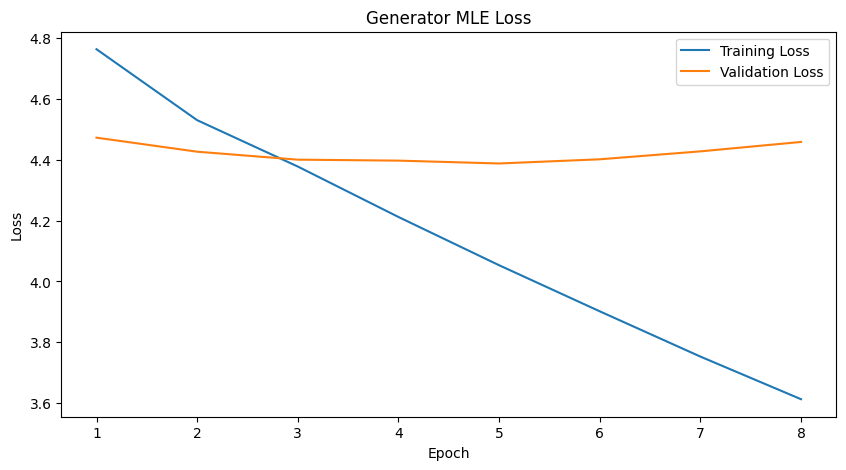


=== GAN Training Epoch 1 ===


Generating Fake Data: 100%|██████████| 238/238 [01:59<00:00,  1.99it/s]


Epoch 1 - Iteration 50 - Discriminator Loss: 1.8855
Epoch 1 - Iteration 100 - Discriminator Loss: 1.7531
Epoch 1 - Iteration 150 - Discriminator Loss: 1.6553
Epoch 1 - Iteration 200 - Discriminator Loss: 1.6030
Epoch 1 - Discriminator Loss: 1.5540


Generator GAN Training Epoch 1:  21%|██        | 50/238 [00:58<03:13,  1.03s/it]

Epoch 1 - Iteration 50 - Generator GAN Loss: 0.6244


Generator GAN Training Epoch 1:  42%|████▏     | 100/238 [01:48<02:23,  1.04s/it]

Epoch 1 - Iteration 100 - Generator GAN Loss: 0.6338


Generator GAN Training Epoch 1:  63%|██████▎   | 150/238 [02:42<01:18,  1.12it/s]

Epoch 1 - Iteration 150 - Generator GAN Loss: 0.6401


Generator GAN Training Epoch 1:  84%|████████▍ | 200/238 [03:31<00:35,  1.07it/s]

Epoch 1 - Iteration 200 - Generator GAN Loss: 0.6459


Generator GAN Training Epoch 1: 100%|██████████| 238/238 [04:12<00:00,  1.06s/it]


Epoch 1 - Generator GAN Loss: 0.6474

=== GAN Training Epoch 2 ===


Generating Fake Data: 100%|██████████| 238/238 [01:59<00:00,  2.00it/s]


Epoch 2 - Iteration 50 - Discriminator Loss: 1.2891
Epoch 2 - Iteration 100 - Discriminator Loss: 1.2441
Epoch 2 - Iteration 150 - Discriminator Loss: 1.1938
Epoch 2 - Iteration 200 - Discriminator Loss: 1.1495
Epoch 2 - Discriminator Loss: 1.1131


Generator GAN Training Epoch 2:  21%|██        | 50/238 [00:49<03:20,  1.07s/it]

Epoch 2 - Iteration 50 - Generator GAN Loss: 0.6949


Generator GAN Training Epoch 2:  42%|████▏     | 100/238 [01:42<02:11,  1.05it/s]

Epoch 2 - Iteration 100 - Generator GAN Loss: 0.6805


Generator GAN Training Epoch 2:  63%|██████▎   | 150/238 [02:38<01:47,  1.22s/it]

Epoch 2 - Iteration 150 - Generator GAN Loss: 0.6685


Generator GAN Training Epoch 2:  84%|████████▍ | 200/238 [03:34<00:47,  1.25s/it]

Epoch 2 - Iteration 200 - Generator GAN Loss: 0.6816


Generator GAN Training Epoch 2: 100%|██████████| 238/238 [04:13<00:00,  1.06s/it]


Epoch 2 - Generator GAN Loss: 0.6899

=== GAN Training Epoch 3 ===


Generating Fake Data: 100%|██████████| 238/238 [01:58<00:00,  2.00it/s]


Epoch 3 - Iteration 50 - Discriminator Loss: 0.9346
Epoch 3 - Iteration 100 - Discriminator Loss: 0.9323
Epoch 3 - Iteration 150 - Discriminator Loss: 0.9293
Epoch 3 - Iteration 200 - Discriminator Loss: 0.8951
Epoch 3 - Discriminator Loss: 0.8649


Generator GAN Training Epoch 3:  21%|██        | 50/238 [00:53<03:21,  1.07s/it]

Epoch 3 - Iteration 50 - Generator GAN Loss: 0.7726


Generator GAN Training Epoch 3:  42%|████▏     | 100/238 [01:49<02:47,  1.21s/it]

Epoch 3 - Iteration 100 - Generator GAN Loss: 0.7632


Generator GAN Training Epoch 3:  63%|██████▎   | 150/238 [02:42<01:20,  1.10it/s]

Epoch 3 - Iteration 150 - Generator GAN Loss: 0.7415


Generator GAN Training Epoch 3:  84%|████████▍ | 200/238 [03:33<00:36,  1.05it/s]

Epoch 3 - Iteration 200 - Generator GAN Loss: 0.7346


Generator GAN Training Epoch 3: 100%|██████████| 238/238 [04:12<00:00,  1.06s/it]


Epoch 3 - Generator GAN Loss: 0.7423

=== GAN Training Epoch 4 ===


Generating Fake Data: 100%|██████████| 238/238 [01:58<00:00,  2.00it/s]


Epoch 4 - Iteration 50 - Discriminator Loss: 0.7163
Epoch 4 - Iteration 100 - Discriminator Loss: 0.6765
Epoch 4 - Iteration 150 - Discriminator Loss: 0.6707
Epoch 4 - Iteration 200 - Discriminator Loss: 0.6685
Epoch 4 - Discriminator Loss: 0.6552


Generator GAN Training Epoch 4:  21%|██        | 50/238 [00:51<03:18,  1.06s/it]

Epoch 4 - Iteration 50 - Generator GAN Loss: 0.9443


Generator GAN Training Epoch 4:  42%|████▏     | 100/238 [01:44<02:51,  1.25s/it]

Epoch 4 - Iteration 100 - Generator GAN Loss: 0.9398


Generator GAN Training Epoch 4:  63%|██████▎   | 150/238 [02:37<01:43,  1.17s/it]

Epoch 4 - Iteration 150 - Generator GAN Loss: 0.9459


Generator GAN Training Epoch 4:  84%|████████▍ | 200/238 [03:29<00:38,  1.01s/it]

Epoch 4 - Iteration 200 - Generator GAN Loss: 0.9494


Generator GAN Training Epoch 4: 100%|██████████| 238/238 [04:13<00:00,  1.07s/it]


Epoch 4 - Generator GAN Loss: 0.9561

=== GAN Training Epoch 5 ===


Generating Fake Data: 100%|██████████| 238/238 [01:58<00:00,  2.00it/s]


Epoch 5 - Iteration 50 - Discriminator Loss: 0.5821
Epoch 5 - Iteration 100 - Discriminator Loss: 0.5738
Epoch 5 - Iteration 150 - Discriminator Loss: 0.5568
Epoch 5 - Iteration 200 - Discriminator Loss: 0.5483
Epoch 5 - Discriminator Loss: 0.5492


Generator GAN Training Epoch 5:  21%|██        | 50/238 [00:54<02:52,  1.09it/s]

Epoch 5 - Iteration 50 - Generator GAN Loss: 1.0893


Generator GAN Training Epoch 5:  42%|████▏     | 100/238 [01:49<02:36,  1.13s/it]

Epoch 5 - Iteration 100 - Generator GAN Loss: 1.0394


Generator GAN Training Epoch 5:  63%|██████▎   | 150/238 [02:39<01:13,  1.20it/s]

Epoch 5 - Iteration 150 - Generator GAN Loss: 1.0331


Generator GAN Training Epoch 5:  84%|████████▍ | 200/238 [03:31<00:38,  1.02s/it]

Epoch 5 - Iteration 200 - Generator GAN Loss: 1.0317


Generator GAN Training Epoch 5: 100%|██████████| 238/238 [04:11<00:00,  1.06s/it]


Epoch 5 - Generator GAN Loss: 0.9895

=== GAN Training Epoch 6 ===


Generating Fake Data: 100%|██████████| 238/238 [01:58<00:00,  2.00it/s]


Epoch 6 - Iteration 50 - Discriminator Loss: 0.4524
Epoch 6 - Iteration 100 - Discriminator Loss: 0.5008
Epoch 6 - Iteration 150 - Discriminator Loss: 0.4765
Epoch 6 - Iteration 200 - Discriminator Loss: 0.4462
Epoch 6 - Discriminator Loss: 0.4473


Generator GAN Training Epoch 6:  21%|██        | 50/238 [00:49<02:59,  1.05it/s]

Epoch 6 - Iteration 50 - Generator GAN Loss: 0.8109


Generator GAN Training Epoch 6:  42%|████▏     | 100/238 [01:43<02:23,  1.04s/it]

Epoch 6 - Iteration 100 - Generator GAN Loss: 0.8014


Generator GAN Training Epoch 6:  63%|██████▎   | 150/238 [02:40<01:30,  1.03s/it]

Epoch 6 - Iteration 150 - Generator GAN Loss: 0.8310


Generator GAN Training Epoch 6:  84%|████████▍ | 200/238 [03:36<00:47,  1.25s/it]

Epoch 6 - Iteration 200 - Generator GAN Loss: 0.8302


Generator GAN Training Epoch 6: 100%|██████████| 238/238 [04:17<00:00,  1.08s/it]


Epoch 6 - Generator GAN Loss: 0.8342

=== GAN Training Epoch 7 ===


Generating Fake Data: 100%|██████████| 238/238 [02:01<00:00,  1.95it/s]


Epoch 7 - Iteration 50 - Discriminator Loss: 0.4865
Epoch 7 - Iteration 100 - Discriminator Loss: 0.4422
Epoch 7 - Iteration 150 - Discriminator Loss: 0.4251
Epoch 7 - Iteration 200 - Discriminator Loss: 0.4237
Epoch 7 - Discriminator Loss: 0.4085


Generator GAN Training Epoch 7:  21%|██        | 50/238 [00:50<03:07,  1.00it/s]

Epoch 7 - Iteration 50 - Generator GAN Loss: 0.8774


Generator GAN Training Epoch 7:  42%|████▏     | 100/238 [01:48<03:13,  1.40s/it]

Epoch 7 - Iteration 100 - Generator GAN Loss: 0.9217


Generator GAN Training Epoch 7:  63%|██████▎   | 150/238 [02:40<01:31,  1.04s/it]

Epoch 7 - Iteration 150 - Generator GAN Loss: 0.9371


Generator GAN Training Epoch 7:  84%|████████▍ | 200/238 [03:32<00:46,  1.23s/it]

Epoch 7 - Iteration 200 - Generator GAN Loss: 0.9855


Generator GAN Training Epoch 7: 100%|██████████| 238/238 [04:11<00:00,  1.06s/it]


Epoch 7 - Generator GAN Loss: 1.0080

=== GAN Training Epoch 8 ===


Generating Fake Data: 100%|██████████| 238/238 [01:58<00:00,  2.01it/s]


Epoch 8 - Iteration 50 - Discriminator Loss: 0.3964
Epoch 8 - Iteration 100 - Discriminator Loss: 0.3783
Epoch 8 - Iteration 150 - Discriminator Loss: 0.3634
Epoch 8 - Iteration 200 - Discriminator Loss: 0.3665
Epoch 8 - Discriminator Loss: 0.3848


Generator GAN Training Epoch 8:  21%|██        | 50/238 [00:50<04:03,  1.29s/it]

Epoch 8 - Iteration 50 - Generator GAN Loss: 0.9737


Generator GAN Training Epoch 8:  42%|████▏     | 100/238 [01:46<02:24,  1.05s/it]

Epoch 8 - Iteration 100 - Generator GAN Loss: 0.9685


Generator GAN Training Epoch 8:  63%|██████▎   | 150/238 [02:40<01:46,  1.21s/it]

Epoch 8 - Iteration 150 - Generator GAN Loss: 0.9425


Generator GAN Training Epoch 8:  84%|████████▍ | 200/238 [03:31<00:46,  1.22s/it]

Epoch 8 - Iteration 200 - Generator GAN Loss: 0.9521


Generator GAN Training Epoch 8: 100%|██████████| 238/238 [04:12<00:00,  1.06s/it]


Epoch 8 - Generator GAN Loss: 0.9565

=== GAN Training Epoch 9 ===


Generating Fake Data: 100%|██████████| 238/238 [01:58<00:00,  2.01it/s]


Epoch 9 - Iteration 50 - Discriminator Loss: 0.3961
Epoch 9 - Iteration 100 - Discriminator Loss: 0.4024
Epoch 9 - Iteration 150 - Discriminator Loss: 0.3912
Epoch 9 - Iteration 200 - Discriminator Loss: 0.3814
Epoch 9 - Discriminator Loss: 0.3775


Generator GAN Training Epoch 9:  21%|██        | 50/238 [00:52<03:17,  1.05s/it]

Epoch 9 - Iteration 50 - Generator GAN Loss: 0.9873


Generator GAN Training Epoch 9:  42%|████▏     | 100/238 [01:44<02:35,  1.13s/it]

Epoch 9 - Iteration 100 - Generator GAN Loss: 0.9952


Generator GAN Training Epoch 9:  63%|██████▎   | 150/238 [02:38<01:30,  1.02s/it]

Epoch 9 - Iteration 150 - Generator GAN Loss: 0.9959


Generator GAN Training Epoch 9:  84%|████████▍ | 200/238 [03:31<01:00,  1.60s/it]

Epoch 9 - Iteration 200 - Generator GAN Loss: 0.9934


Generator GAN Training Epoch 9: 100%|██████████| 238/238 [04:11<00:00,  1.06s/it]


Epoch 9 - Generator GAN Loss: 0.9972

=== GAN Training Epoch 10 ===


Generating Fake Data: 100%|██████████| 238/238 [01:58<00:00,  2.01it/s]


Epoch 10 - Iteration 50 - Discriminator Loss: 0.3516
Epoch 10 - Iteration 100 - Discriminator Loss: 0.3226
Epoch 10 - Iteration 150 - Discriminator Loss: 0.3199
Epoch 10 - Iteration 200 - Discriminator Loss: 0.3206
Epoch 10 - Discriminator Loss: 0.3160


Generator GAN Training Epoch 10:  21%|██        | 50/238 [00:52<03:09,  1.01s/it]

Epoch 10 - Iteration 50 - Generator GAN Loss: 1.0174


Generator GAN Training Epoch 10:  42%|████▏     | 100/238 [01:47<02:40,  1.16s/it]

Epoch 10 - Iteration 100 - Generator GAN Loss: 1.0835


Generator GAN Training Epoch 10:  63%|██████▎   | 150/238 [02:40<01:27,  1.00it/s]

Epoch 10 - Iteration 150 - Generator GAN Loss: 1.1213


Generator GAN Training Epoch 10:  84%|████████▍ | 200/238 [03:32<00:36,  1.05it/s]

Epoch 10 - Iteration 200 - Generator GAN Loss: 1.0999


Generator GAN Training Epoch 10: 100%|██████████| 238/238 [04:12<00:00,  1.06s/it]


Epoch 10 - Generator GAN Loss: 1.0700

=== GAN Training Epoch 11 ===


Generating Fake Data: 100%|██████████| 238/238 [01:58<00:00,  2.01it/s]


Epoch 11 - Iteration 50 - Discriminator Loss: 0.3956
Epoch 11 - Iteration 100 - Discriminator Loss: 0.3033
Epoch 11 - Iteration 150 - Discriminator Loss: 0.3226
Epoch 11 - Iteration 200 - Discriminator Loss: 0.3093
Epoch 11 - Discriminator Loss: 0.3058


Generator GAN Training Epoch 11:  21%|██        | 50/238 [00:50<03:00,  1.04it/s]

Epoch 11 - Iteration 50 - Generator GAN Loss: 0.8002


Generator GAN Training Epoch 11:  42%|████▏     | 100/238 [01:40<02:12,  1.04it/s]

Epoch 11 - Iteration 100 - Generator GAN Loss: 0.8974


Generator GAN Training Epoch 11:  63%|██████▎   | 150/238 [02:31<01:30,  1.02s/it]

Epoch 11 - Iteration 150 - Generator GAN Loss: 0.9203


Generator GAN Training Epoch 11:  84%|████████▍ | 200/238 [03:27<00:36,  1.04it/s]

Epoch 11 - Iteration 200 - Generator GAN Loss: 0.9137


Generator GAN Training Epoch 11: 100%|██████████| 238/238 [04:11<00:00,  1.05s/it]


Epoch 11 - Generator GAN Loss: 0.9193

=== GAN Training Epoch 12 ===


Generating Fake Data: 100%|██████████| 238/238 [02:00<00:00,  1.97it/s]


Epoch 12 - Iteration 50 - Discriminator Loss: 0.3560
Epoch 12 - Iteration 100 - Discriminator Loss: 0.3006
Epoch 12 - Iteration 150 - Discriminator Loss: 0.2985
Epoch 12 - Iteration 200 - Discriminator Loss: 0.2819
Epoch 12 - Discriminator Loss: 0.2795


Generator GAN Training Epoch 12:  21%|██        | 50/238 [00:56<04:57,  1.58s/it]

Epoch 12 - Iteration 50 - Generator GAN Loss: 1.0534


Generator GAN Training Epoch 12:  42%|████▏     | 100/238 [01:46<02:11,  1.05it/s]

Epoch 12 - Iteration 100 - Generator GAN Loss: 1.1347


Generator GAN Training Epoch 12:  63%|██████▎   | 150/238 [02:40<01:33,  1.06s/it]

Epoch 12 - Iteration 150 - Generator GAN Loss: 1.0988


Generator GAN Training Epoch 12:  84%|████████▍ | 200/238 [03:36<00:42,  1.11s/it]

Epoch 12 - Iteration 200 - Generator GAN Loss: 1.1018


Generator GAN Training Epoch 12: 100%|██████████| 238/238 [04:19<00:00,  1.09s/it]


Epoch 12 - Generator GAN Loss: 1.0825

=== GAN Training Epoch 13 ===


Generating Fake Data: 100%|██████████| 238/238 [02:01<00:00,  1.97it/s]


Epoch 13 - Iteration 50 - Discriminator Loss: 0.2329
Epoch 13 - Iteration 100 - Discriminator Loss: 0.2563
Epoch 13 - Iteration 150 - Discriminator Loss: 0.2825
Epoch 13 - Iteration 200 - Discriminator Loss: 0.2677
Epoch 13 - Discriminator Loss: 0.2693


Generator GAN Training Epoch 13:  21%|██        | 50/238 [00:55<03:23,  1.08s/it]

Epoch 13 - Iteration 50 - Generator GAN Loss: 1.0939


Generator GAN Training Epoch 13:  42%|████▏     | 100/238 [01:48<02:11,  1.05it/s]

Epoch 13 - Iteration 100 - Generator GAN Loss: 1.0947


Generator GAN Training Epoch 13:  63%|██████▎   | 150/238 [02:44<01:34,  1.07s/it]

Epoch 13 - Iteration 150 - Generator GAN Loss: 1.0665


Generator GAN Training Epoch 13:  84%|████████▍ | 200/238 [03:35<00:38,  1.00s/it]

Epoch 13 - Iteration 200 - Generator GAN Loss: 1.0303


Generator GAN Training Epoch 13: 100%|██████████| 238/238 [04:18<00:00,  1.08s/it]


Epoch 13 - Generator GAN Loss: 1.0442

=== GAN Training Epoch 14 ===


Generating Fake Data: 100%|██████████| 238/238 [02:00<00:00,  1.97it/s]


Epoch 14 - Iteration 50 - Discriminator Loss: 0.2849
Epoch 14 - Iteration 100 - Discriminator Loss: 0.2632
Epoch 14 - Iteration 150 - Discriminator Loss: 0.2335
Epoch 14 - Iteration 200 - Discriminator Loss: 0.2470
Epoch 14 - Discriminator Loss: 0.2498


Generator GAN Training Epoch 14:  21%|██        | 50/238 [00:52<03:26,  1.10s/it]

Epoch 14 - Iteration 50 - Generator GAN Loss: 1.1547


Generator GAN Training Epoch 14:  42%|████▏     | 100/238 [01:45<02:20,  1.02s/it]

Epoch 14 - Iteration 100 - Generator GAN Loss: 1.2431


Generator GAN Training Epoch 14:  63%|██████▎   | 150/238 [02:39<01:26,  1.02it/s]

Epoch 14 - Iteration 150 - Generator GAN Loss: 1.1757


Generator GAN Training Epoch 14:  84%|████████▍ | 200/238 [03:35<00:33,  1.12it/s]

Epoch 14 - Iteration 200 - Generator GAN Loss: 1.2289


Generator GAN Training Epoch 14: 100%|██████████| 238/238 [04:19<00:00,  1.09s/it]


Epoch 14 - Generator GAN Loss: 1.1825

=== GAN Training Epoch 15 ===


Generating Fake Data: 100%|██████████| 238/238 [02:01<00:00,  1.97it/s]


Epoch 15 - Iteration 50 - Discriminator Loss: 0.1886
Epoch 15 - Iteration 100 - Discriminator Loss: 0.2129
Epoch 15 - Iteration 150 - Discriminator Loss: 0.2527
Epoch 15 - Iteration 200 - Discriminator Loss: 0.2620
Epoch 15 - Discriminator Loss: 0.2652


Generator GAN Training Epoch 15:  21%|██        | 50/238 [00:53<02:53,  1.08it/s]

Epoch 15 - Iteration 50 - Generator GAN Loss: 1.3233


Generator GAN Training Epoch 15:  42%|████▏     | 100/238 [01:47<02:19,  1.01s/it]

Epoch 15 - Iteration 100 - Generator GAN Loss: 1.3817


Generator GAN Training Epoch 15:  63%|██████▎   | 150/238 [02:46<01:33,  1.06s/it]

Epoch 15 - Iteration 150 - Generator GAN Loss: 1.4450


Generator GAN Training Epoch 15:  84%|████████▍ | 200/238 [03:40<00:38,  1.02s/it]

Epoch 15 - Iteration 200 - Generator GAN Loss: 1.4740


Generator GAN Training Epoch 15: 100%|██████████| 238/238 [04:18<00:00,  1.09s/it]


Epoch 15 - Generator GAN Loss: 1.4786

=== GAN Training Epoch 16 ===


Generating Fake Data: 100%|██████████| 238/238 [02:00<00:00,  1.97it/s]


Epoch 16 - Iteration 50 - Discriminator Loss: 0.2441
Epoch 16 - Iteration 100 - Discriminator Loss: 0.2463
Epoch 16 - Iteration 150 - Discriminator Loss: 0.2399
Epoch 16 - Iteration 200 - Discriminator Loss: 0.2474
Epoch 16 - Discriminator Loss: 0.2398


Generator GAN Training Epoch 16:  21%|██        | 50/238 [01:00<03:35,  1.15s/it]

Epoch 16 - Iteration 50 - Generator GAN Loss: 1.3448


Generator GAN Training Epoch 16:  42%|████▏     | 100/238 [01:55<02:17,  1.00it/s]

Epoch 16 - Iteration 100 - Generator GAN Loss: 1.2859


Generator GAN Training Epoch 16:  63%|██████▎   | 150/238 [03:01<01:40,  1.14s/it]

Epoch 16 - Iteration 150 - Generator GAN Loss: 1.2231


Generator GAN Training Epoch 16:  84%|████████▍ | 200/238 [03:56<00:41,  1.10s/it]

Epoch 16 - Iteration 200 - Generator GAN Loss: 1.1937


Generator GAN Training Epoch 16: 100%|██████████| 238/238 [04:36<00:00,  1.16s/it]


Epoch 16 - Generator GAN Loss: 1.1968

=== GAN Training Epoch 17 ===


Generating Fake Data: 100%|██████████| 238/238 [02:01<00:00,  1.96it/s]


Epoch 17 - Iteration 50 - Discriminator Loss: 0.3146
Epoch 17 - Iteration 100 - Discriminator Loss: 0.2935
Epoch 17 - Iteration 150 - Discriminator Loss: 0.2427
Epoch 17 - Iteration 200 - Discriminator Loss: 0.2360
Epoch 17 - Discriminator Loss: 0.2322


Generator GAN Training Epoch 17:  21%|██        | 50/238 [00:59<03:49,  1.22s/it]

Epoch 17 - Iteration 50 - Generator GAN Loss: 0.9993


Generator GAN Training Epoch 17:  42%|████▏     | 100/238 [01:53<02:48,  1.22s/it]

Epoch 17 - Iteration 100 - Generator GAN Loss: 0.9621


Generator GAN Training Epoch 17:  63%|██████▎   | 150/238 [02:48<01:37,  1.11s/it]

Epoch 17 - Iteration 150 - Generator GAN Loss: 0.9918


Generator GAN Training Epoch 17:  84%|████████▍ | 200/238 [03:47<00:38,  1.00s/it]

Epoch 17 - Iteration 200 - Generator GAN Loss: 0.9668


Generator GAN Training Epoch 17: 100%|██████████| 238/238 [04:29<00:00,  1.13s/it]


Epoch 17 - Generator GAN Loss: 1.0022

=== GAN Training Epoch 18 ===


Generating Fake Data: 100%|██████████| 238/238 [02:03<00:00,  1.93it/s]


Epoch 18 - Iteration 50 - Discriminator Loss: 0.2146
Epoch 18 - Iteration 100 - Discriminator Loss: 0.2388
Epoch 18 - Iteration 150 - Discriminator Loss: 0.2297
Epoch 18 - Iteration 200 - Discriminator Loss: 0.2095
Epoch 18 - Discriminator Loss: 0.1985


Generator GAN Training Epoch 18:  21%|██        | 50/238 [00:53<03:15,  1.04s/it]

Epoch 18 - Iteration 50 - Generator GAN Loss: 1.2713


Generator GAN Training Epoch 18:  42%|████▏     | 100/238 [01:50<02:32,  1.10s/it]

Epoch 18 - Iteration 100 - Generator GAN Loss: 1.2357


Generator GAN Training Epoch 18:  63%|██████▎   | 150/238 [02:47<01:28,  1.01s/it]

Epoch 18 - Iteration 150 - Generator GAN Loss: 1.2465


Generator GAN Training Epoch 18:  84%|████████▍ | 200/238 [03:43<00:36,  1.05it/s]

Epoch 18 - Iteration 200 - Generator GAN Loss: 1.2245


Generator GAN Training Epoch 18: 100%|██████████| 238/238 [04:23<00:00,  1.11s/it]


Epoch 18 - Generator GAN Loss: 1.2033

=== GAN Training Epoch 19 ===


Generating Fake Data: 100%|██████████| 238/238 [02:02<00:00,  1.95it/s]


Epoch 19 - Iteration 50 - Discriminator Loss: 0.1899
Epoch 19 - Iteration 100 - Discriminator Loss: 0.2493
Epoch 19 - Iteration 150 - Discriminator Loss: 0.2262
Epoch 19 - Iteration 200 - Discriminator Loss: 0.2112
Epoch 19 - Discriminator Loss: 0.2072


Generator GAN Training Epoch 19:  21%|██        | 50/238 [00:53<02:54,  1.07it/s]

Epoch 19 - Iteration 50 - Generator GAN Loss: 1.1844


Generator GAN Training Epoch 19:  42%|████▏     | 100/238 [01:50<02:55,  1.27s/it]

Epoch 19 - Iteration 100 - Generator GAN Loss: 1.1185


Generator GAN Training Epoch 19:  63%|██████▎   | 150/238 [02:47<01:24,  1.04it/s]

Epoch 19 - Iteration 150 - Generator GAN Loss: 1.1354


Generator GAN Training Epoch 19:  84%|████████▍ | 200/238 [03:39<00:44,  1.18s/it]

Epoch 19 - Iteration 200 - Generator GAN Loss: 1.1465


Generator GAN Training Epoch 19: 100%|██████████| 238/238 [04:21<00:00,  1.10s/it]


Epoch 19 - Generator GAN Loss: 1.1855

=== GAN Training Epoch 20 ===


Generating Fake Data: 100%|██████████| 238/238 [02:00<00:00,  1.97it/s]


Epoch 20 - Iteration 50 - Discriminator Loss: 0.2075
Epoch 20 - Iteration 100 - Discriminator Loss: 0.2364
Epoch 20 - Iteration 150 - Discriminator Loss: 0.2276
Epoch 20 - Iteration 200 - Discriminator Loss: 0.2545
Epoch 20 - Discriminator Loss: 0.2490


Generator GAN Training Epoch 20:  21%|██        | 50/238 [00:53<02:54,  1.07it/s]

Epoch 20 - Iteration 50 - Generator GAN Loss: 1.1798


Generator GAN Training Epoch 20:  42%|████▏     | 100/238 [01:47<02:06,  1.09it/s]

Epoch 20 - Iteration 100 - Generator GAN Loss: 1.1252


Generator GAN Training Epoch 20:  63%|██████▎   | 150/238 [02:40<01:35,  1.08s/it]

Epoch 20 - Iteration 150 - Generator GAN Loss: 1.1151


Generator GAN Training Epoch 20:  84%|████████▍ | 200/238 [03:37<00:36,  1.05it/s]

Epoch 20 - Iteration 200 - Generator GAN Loss: 1.1508


Generator GAN Training Epoch 20: 100%|██████████| 238/238 [04:18<00:00,  1.09s/it]


Epoch 20 - Generator GAN Loss: 1.1418

=== GAN Training Epoch 21 ===


Generating Fake Data: 100%|██████████| 238/238 [02:01<00:00,  1.95it/s]


Epoch 21 - Iteration 50 - Discriminator Loss: 0.2022
Epoch 21 - Iteration 100 - Discriminator Loss: 0.1782
Epoch 21 - Iteration 150 - Discriminator Loss: 0.2001
Epoch 21 - Iteration 200 - Discriminator Loss: 0.1996
Epoch 21 - Discriminator Loss: 0.2095


Generator GAN Training Epoch 21:  21%|██        | 50/238 [00:57<03:14,  1.03s/it]

Epoch 21 - Iteration 50 - Generator GAN Loss: 1.3025


Generator GAN Training Epoch 21:  42%|████▏     | 100/238 [01:54<02:41,  1.17s/it]

Epoch 21 - Iteration 100 - Generator GAN Loss: 1.4364


Generator GAN Training Epoch 21:  63%|██████▎   | 150/238 [02:50<02:14,  1.53s/it]

Epoch 21 - Iteration 150 - Generator GAN Loss: 1.4004


Generator GAN Training Epoch 21:  84%|████████▍ | 200/238 [03:47<00:44,  1.18s/it]

Epoch 21 - Iteration 200 - Generator GAN Loss: 1.3648


Generator GAN Training Epoch 21: 100%|██████████| 238/238 [04:29<00:00,  1.13s/it]


Epoch 21 - Generator GAN Loss: 1.4185

=== GAN Training Epoch 22 ===


Generating Fake Data: 100%|██████████| 238/238 [02:04<00:00,  1.90it/s]


Epoch 22 - Iteration 50 - Discriminator Loss: 0.1698
Epoch 22 - Iteration 100 - Discriminator Loss: 0.1322
Epoch 22 - Iteration 150 - Discriminator Loss: 0.1632
Epoch 22 - Iteration 200 - Discriminator Loss: 0.1692
Epoch 22 - Discriminator Loss: 0.1772


Generator GAN Training Epoch 22:  21%|██        | 50/238 [00:57<03:56,  1.26s/it]

Epoch 22 - Iteration 50 - Generator GAN Loss: 1.4028


Generator GAN Training Epoch 22:  42%|████▏     | 100/238 [01:55<02:44,  1.19s/it]

Epoch 22 - Iteration 100 - Generator GAN Loss: 1.3235


Generator GAN Training Epoch 22:  63%|██████▎   | 150/238 [02:54<01:26,  1.02it/s]

Epoch 22 - Iteration 150 - Generator GAN Loss: 1.2413


Generator GAN Training Epoch 22:  84%|████████▍ | 200/238 [03:49<00:45,  1.19s/it]

Epoch 22 - Iteration 200 - Generator GAN Loss: 1.1644


Generator GAN Training Epoch 22: 100%|██████████| 238/238 [04:30<00:00,  1.13s/it]


Epoch 22 - Generator GAN Loss: 1.1214

=== GAN Training Epoch 23 ===


Generating Fake Data: 100%|██████████| 238/238 [02:04<00:00,  1.91it/s]


Epoch 23 - Iteration 50 - Discriminator Loss: 0.1568
Epoch 23 - Iteration 100 - Discriminator Loss: 0.1934
Epoch 23 - Iteration 150 - Discriminator Loss: 0.1796
Epoch 23 - Iteration 200 - Discriminator Loss: 0.1900
Epoch 23 - Discriminator Loss: 0.1896


Generator GAN Training Epoch 23:  21%|██        | 50/238 [00:58<04:41,  1.50s/it]

Epoch 23 - Iteration 50 - Generator GAN Loss: 0.9997


Generator GAN Training Epoch 23:  42%|████▏     | 100/238 [01:54<02:08,  1.08it/s]

Epoch 23 - Iteration 100 - Generator GAN Loss: 1.1600


Generator GAN Training Epoch 23:  63%|██████▎   | 150/238 [02:48<01:36,  1.10s/it]

Epoch 23 - Iteration 150 - Generator GAN Loss: 1.0855


Generator GAN Training Epoch 23:  84%|████████▍ | 200/238 [03:45<00:57,  1.51s/it]

Epoch 23 - Iteration 200 - Generator GAN Loss: 1.0375


Generator GAN Training Epoch 23: 100%|██████████| 238/238 [04:28<00:00,  1.13s/it]


Epoch 23 - Generator GAN Loss: 1.0711

=== GAN Training Epoch 24 ===


Generating Fake Data: 100%|██████████| 238/238 [02:04<00:00,  1.91it/s]


Epoch 24 - Iteration 50 - Discriminator Loss: 0.1478
Epoch 24 - Iteration 100 - Discriminator Loss: 0.1496
Epoch 24 - Iteration 150 - Discriminator Loss: 0.1629
Epoch 24 - Iteration 200 - Discriminator Loss: 0.1807
Epoch 24 - Discriminator Loss: 0.1973


Generator GAN Training Epoch 24:  21%|██        | 50/238 [00:54<03:19,  1.06s/it]

Epoch 24 - Iteration 50 - Generator GAN Loss: 1.5213


Generator GAN Training Epoch 24:  42%|████▏     | 100/238 [01:55<02:54,  1.26s/it]

Epoch 24 - Iteration 100 - Generator GAN Loss: 1.6184


Generator GAN Training Epoch 24:  63%|██████▎   | 150/238 [02:55<01:52,  1.28s/it]

Epoch 24 - Iteration 150 - Generator GAN Loss: 1.5912


Generator GAN Training Epoch 24:  84%|████████▍ | 200/238 [03:47<00:36,  1.04it/s]

Epoch 24 - Iteration 200 - Generator GAN Loss: 1.5903


Generator GAN Training Epoch 24: 100%|██████████| 238/238 [04:30<00:00,  1.14s/it]


Epoch 24 - Generator GAN Loss: 1.5577

=== GAN Training Epoch 25 ===


Generating Fake Data: 100%|██████████| 238/238 [02:05<00:00,  1.89it/s]


Epoch 25 - Iteration 50 - Discriminator Loss: 0.1714
Epoch 25 - Iteration 100 - Discriminator Loss: 0.1741
Epoch 25 - Iteration 150 - Discriminator Loss: 0.1607
Epoch 25 - Iteration 200 - Discriminator Loss: 0.1970
Epoch 25 - Discriminator Loss: 0.2031


Generator GAN Training Epoch 25:  21%|██        | 50/238 [00:59<03:31,  1.13s/it]

Epoch 25 - Iteration 50 - Generator GAN Loss: 1.3589


Generator GAN Training Epoch 25:  42%|████▏     | 100/238 [01:52<02:07,  1.08it/s]

Epoch 25 - Iteration 100 - Generator GAN Loss: 1.2924


Generator GAN Training Epoch 25:  63%|██████▎   | 150/238 [02:49<01:21,  1.08it/s]

Epoch 25 - Iteration 150 - Generator GAN Loss: 1.2381


Generator GAN Training Epoch 25:  84%|████████▍ | 200/238 [03:42<00:36,  1.03it/s]

Epoch 25 - Iteration 200 - Generator GAN Loss: 1.3101


Generator GAN Training Epoch 25: 100%|██████████| 238/238 [04:28<00:00,  1.13s/it]


Epoch 25 - Generator GAN Loss: 1.2853

=== GAN Training Epoch 26 ===


Generating Fake Data: 100%|██████████| 238/238 [02:05<00:00,  1.90it/s]


Epoch 26 - Iteration 50 - Discriminator Loss: 0.1559
Epoch 26 - Iteration 100 - Discriminator Loss: 0.1584
Epoch 26 - Iteration 150 - Discriminator Loss: 0.1807
Epoch 26 - Iteration 200 - Discriminator Loss: 0.1791
Epoch 26 - Discriminator Loss: 0.1802


Generator GAN Training Epoch 26:  21%|██        | 50/238 [00:57<03:35,  1.15s/it]

Epoch 26 - Iteration 50 - Generator GAN Loss: 1.0991


Generator GAN Training Epoch 26:  42%|████▏     | 100/238 [01:52<02:51,  1.24s/it]

Epoch 26 - Iteration 100 - Generator GAN Loss: 1.0750


Generator GAN Training Epoch 26:  63%|██████▎   | 150/238 [02:48<01:34,  1.07s/it]

Epoch 26 - Iteration 150 - Generator GAN Loss: 1.1564


Generator GAN Training Epoch 26:  84%|████████▍ | 200/238 [03:46<00:49,  1.29s/it]

Epoch 26 - Iteration 200 - Generator GAN Loss: 1.1345


Generator GAN Training Epoch 26: 100%|██████████| 238/238 [04:28<00:00,  1.13s/it]


Epoch 26 - Generator GAN Loss: 1.1605

=== GAN Training Epoch 27 ===


Generating Fake Data: 100%|██████████| 238/238 [02:05<00:00,  1.90it/s]


Epoch 27 - Iteration 50 - Discriminator Loss: 0.1928
Epoch 27 - Iteration 100 - Discriminator Loss: 0.1650
Epoch 27 - Iteration 150 - Discriminator Loss: 0.1670
Epoch 27 - Iteration 200 - Discriminator Loss: 0.1717
Epoch 27 - Discriminator Loss: 0.1719


Generator GAN Training Epoch 27:  21%|██        | 50/238 [00:56<03:25,  1.09s/it]

Epoch 27 - Iteration 50 - Generator GAN Loss: 1.1109


Generator GAN Training Epoch 27:  42%|████▏     | 100/238 [01:55<02:23,  1.04s/it]

Epoch 27 - Iteration 100 - Generator GAN Loss: 1.1887


Generator GAN Training Epoch 27:  63%|██████▎   | 150/238 [02:47<01:29,  1.01s/it]

Epoch 27 - Iteration 150 - Generator GAN Loss: 1.1662


Generator GAN Training Epoch 27:  84%|████████▍ | 200/238 [03:48<00:47,  1.24s/it]

Epoch 27 - Iteration 200 - Generator GAN Loss: 1.1585


Generator GAN Training Epoch 27: 100%|██████████| 238/238 [04:28<00:00,  1.13s/it]


Epoch 27 - Generator GAN Loss: 1.1041

=== GAN Training Epoch 28 ===


Generating Fake Data: 100%|██████████| 238/238 [02:05<00:00,  1.90it/s]


Epoch 28 - Iteration 50 - Discriminator Loss: 0.1762
Epoch 28 - Iteration 100 - Discriminator Loss: 0.2001
Epoch 28 - Iteration 150 - Discriminator Loss: 0.1618
Epoch 28 - Iteration 200 - Discriminator Loss: 0.1590
Epoch 28 - Discriminator Loss: 0.1832


Generator GAN Training Epoch 28:  21%|██        | 50/238 [00:54<02:57,  1.06it/s]

Epoch 28 - Iteration 50 - Generator GAN Loss: 0.9665


Generator GAN Training Epoch 28:  42%|████▏     | 100/238 [01:55<02:10,  1.06it/s]

Epoch 28 - Iteration 100 - Generator GAN Loss: 1.1047


Generator GAN Training Epoch 28:  63%|██████▎   | 150/238 [02:48<01:27,  1.01it/s]

Epoch 28 - Iteration 150 - Generator GAN Loss: 1.0819


Generator GAN Training Epoch 28:  84%|████████▍ | 200/238 [03:44<01:04,  1.69s/it]

Epoch 28 - Iteration 200 - Generator GAN Loss: 1.0809


Generator GAN Training Epoch 28: 100%|██████████| 238/238 [04:28<00:00,  1.13s/it]


Epoch 28 - Generator GAN Loss: 1.1428

=== GAN Training Epoch 29 ===


Generating Fake Data: 100%|██████████| 238/238 [02:06<00:00,  1.88it/s]


Epoch 29 - Iteration 50 - Discriminator Loss: 0.1396
Epoch 29 - Iteration 100 - Discriminator Loss: 0.1582
Epoch 29 - Iteration 150 - Discriminator Loss: 0.1819
Epoch 29 - Iteration 200 - Discriminator Loss: 0.1992
Epoch 29 - Discriminator Loss: 0.2075


Generator GAN Training Epoch 29:  21%|██        | 50/238 [00:56<03:10,  1.01s/it]

Epoch 29 - Iteration 50 - Generator GAN Loss: 1.3066


Generator GAN Training Epoch 29:  42%|████▏     | 100/238 [01:51<02:46,  1.21s/it]

Epoch 29 - Iteration 100 - Generator GAN Loss: 1.2025


Generator GAN Training Epoch 29:  63%|██████▎   | 150/238 [02:52<01:57,  1.34s/it]

Epoch 29 - Iteration 150 - Generator GAN Loss: 1.2208


Generator GAN Training Epoch 29:  84%|████████▍ | 200/238 [03:47<00:46,  1.21s/it]

Epoch 29 - Iteration 200 - Generator GAN Loss: 1.1820


Generator GAN Training Epoch 29: 100%|██████████| 238/238 [04:31<00:00,  1.14s/it]


Epoch 29 - Generator GAN Loss: 1.2210

=== GAN Training Epoch 30 ===


Generating Fake Data: 100%|██████████| 238/238 [02:05<00:00,  1.90it/s]


Epoch 30 - Iteration 50 - Discriminator Loss: 0.1860
Epoch 30 - Iteration 100 - Discriminator Loss: 0.1563
Epoch 30 - Iteration 150 - Discriminator Loss: 0.1745
Epoch 30 - Iteration 200 - Discriminator Loss: 0.1761
Epoch 30 - Discriminator Loss: 0.1839


Generator GAN Training Epoch 30:  21%|██        | 50/238 [00:59<03:56,  1.26s/it]

Epoch 30 - Iteration 50 - Generator GAN Loss: 1.5077


Generator GAN Training Epoch 30:  42%|████▏     | 100/238 [01:56<02:26,  1.06s/it]

Epoch 30 - Iteration 100 - Generator GAN Loss: 1.3919


Generator GAN Training Epoch 30:  63%|██████▎   | 150/238 [02:51<01:48,  1.23s/it]

Epoch 30 - Iteration 150 - Generator GAN Loss: 1.4803


Generator GAN Training Epoch 30:  84%|████████▍ | 200/238 [03:45<00:42,  1.11s/it]

Epoch 30 - Iteration 200 - Generator GAN Loss: 1.4944


Generator GAN Training Epoch 30: 100%|██████████| 238/238 [04:29<00:00,  1.13s/it]


Epoch 30 - Generator GAN Loss: 1.5082

=== GAN Training Epoch 31 ===


Generating Fake Data: 100%|██████████| 238/238 [02:05<00:00,  1.90it/s]


Epoch 31 - Iteration 50 - Discriminator Loss: 0.2921
Epoch 31 - Iteration 100 - Discriminator Loss: 0.1949
Epoch 31 - Iteration 150 - Discriminator Loss: 0.2048
Epoch 31 - Iteration 200 - Discriminator Loss: 0.1909
Epoch 31 - Discriminator Loss: 0.1939


Generator GAN Training Epoch 31:  21%|██        | 50/238 [00:58<03:06,  1.01it/s]

Epoch 31 - Iteration 50 - Generator GAN Loss: 1.4314


Generator GAN Training Epoch 31:  42%|████▏     | 100/238 [01:54<03:06,  1.35s/it]

Epoch 31 - Iteration 100 - Generator GAN Loss: 1.3063


Generator GAN Training Epoch 31:  63%|██████▎   | 150/238 [02:50<01:39,  1.14s/it]

Epoch 31 - Iteration 150 - Generator GAN Loss: 1.2545


Generator GAN Training Epoch 31:  84%|████████▍ | 200/238 [03:46<00:48,  1.27s/it]

Epoch 31 - Iteration 200 - Generator GAN Loss: 1.2939


Generator GAN Training Epoch 31: 100%|██████████| 238/238 [04:27<00:00,  1.13s/it]


Epoch 31 - Generator GAN Loss: 1.3303

=== GAN Training Epoch 32 ===


Generating Fake Data: 100%|██████████| 238/238 [02:04<00:00,  1.91it/s]


Epoch 32 - Iteration 50 - Discriminator Loss: 0.2189
Epoch 32 - Iteration 100 - Discriminator Loss: 0.1511
Epoch 32 - Iteration 150 - Discriminator Loss: 0.1591
Epoch 32 - Iteration 200 - Discriminator Loss: 0.1565
Epoch 32 - Discriminator Loss: 0.1780


Generator GAN Training Epoch 32:  21%|██        | 50/238 [01:00<03:39,  1.17s/it]

Epoch 32 - Iteration 50 - Generator GAN Loss: 1.4045


Generator GAN Training Epoch 32:  42%|████▏     | 100/238 [01:56<02:26,  1.06s/it]

Epoch 32 - Iteration 100 - Generator GAN Loss: 1.4766


Generator GAN Training Epoch 32:  63%|██████▎   | 150/238 [02:50<01:27,  1.00it/s]

Epoch 32 - Iteration 150 - Generator GAN Loss: 1.4606


Generator GAN Training Epoch 32:  84%|████████▍ | 200/238 [03:46<00:54,  1.44s/it]

Epoch 32 - Iteration 200 - Generator GAN Loss: 1.4389


Generator GAN Training Epoch 32: 100%|██████████| 238/238 [04:29<00:00,  1.13s/it]


Epoch 32 - Generator GAN Loss: 1.4350

=== GAN Training Epoch 33 ===


Generating Fake Data: 100%|██████████| 238/238 [02:05<00:00,  1.90it/s]


Epoch 33 - Iteration 50 - Discriminator Loss: 0.1423
Epoch 33 - Iteration 100 - Discriminator Loss: 0.1598
Epoch 33 - Iteration 150 - Discriminator Loss: 0.1689
Epoch 33 - Iteration 200 - Discriminator Loss: 0.1664
Epoch 33 - Discriminator Loss: 0.1640


Generator GAN Training Epoch 33:  21%|██        | 50/238 [00:50<02:56,  1.07it/s]

Epoch 33 - Iteration 50 - Generator GAN Loss: 1.1884


Generator GAN Training Epoch 33:  42%|████▏     | 100/238 [01:50<03:18,  1.43s/it]

Epoch 33 - Iteration 100 - Generator GAN Loss: 1.4345


Generator GAN Training Epoch 33:  63%|██████▎   | 150/238 [02:46<01:37,  1.11s/it]

Epoch 33 - Iteration 150 - Generator GAN Loss: 1.3147


Generator GAN Training Epoch 33:  84%|████████▍ | 200/238 [03:46<00:36,  1.05it/s]

Epoch 33 - Iteration 200 - Generator GAN Loss: 1.3420


Generator GAN Training Epoch 33: 100%|██████████| 238/238 [04:28<00:00,  1.13s/it]


Epoch 33 - Generator GAN Loss: 1.3227

=== GAN Training Epoch 34 ===


Generating Fake Data: 100%|██████████| 238/238 [02:05<00:00,  1.89it/s]


Epoch 34 - Iteration 50 - Discriminator Loss: 0.1536
Epoch 34 - Iteration 100 - Discriminator Loss: 0.1434
Epoch 34 - Iteration 150 - Discriminator Loss: 0.1605
Epoch 34 - Iteration 200 - Discriminator Loss: 0.1764
Epoch 34 - Discriminator Loss: 0.1696


Generator GAN Training Epoch 34:  21%|██        | 50/238 [00:58<03:20,  1.07s/it]

Epoch 34 - Iteration 50 - Generator GAN Loss: 1.1408


Generator GAN Training Epoch 34:  42%|████▏     | 100/238 [01:55<02:17,  1.01it/s]

Epoch 34 - Iteration 100 - Generator GAN Loss: 1.1910


Generator GAN Training Epoch 34:  63%|██████▎   | 150/238 [02:54<01:36,  1.10s/it]

Epoch 34 - Iteration 150 - Generator GAN Loss: 1.2694


Generator GAN Training Epoch 34:  84%|████████▍ | 200/238 [03:46<00:40,  1.07s/it]

Epoch 34 - Iteration 200 - Generator GAN Loss: 1.3406


Generator GAN Training Epoch 34: 100%|██████████| 238/238 [04:29<00:00,  1.13s/it]


Epoch 34 - Generator GAN Loss: 1.3561

=== GAN Training Epoch 35 ===


Generating Fake Data: 100%|██████████| 238/238 [02:04<00:00,  1.90it/s]


Epoch 35 - Iteration 50 - Discriminator Loss: 0.2237
Epoch 35 - Iteration 100 - Discriminator Loss: 0.2384
Epoch 35 - Iteration 150 - Discriminator Loss: 0.2197
Epoch 35 - Iteration 200 - Discriminator Loss: 0.2274
Epoch 35 - Discriminator Loss: 0.2024


Generator GAN Training Epoch 35:  21%|██        | 50/238 [00:52<03:22,  1.08s/it]

Epoch 35 - Iteration 50 - Generator GAN Loss: 1.3097


Generator GAN Training Epoch 35:  42%|████▏     | 100/238 [01:46<02:19,  1.01s/it]

Epoch 35 - Iteration 100 - Generator GAN Loss: 1.4284


Generator GAN Training Epoch 35:  63%|██████▎   | 150/238 [02:41<01:30,  1.02s/it]

Epoch 35 - Iteration 150 - Generator GAN Loss: 1.3255


Generator GAN Training Epoch 35:  84%|████████▍ | 200/238 [03:39<00:43,  1.14s/it]

Epoch 35 - Iteration 200 - Generator GAN Loss: 1.2893


Generator GAN Training Epoch 35: 100%|██████████| 238/238 [04:28<00:00,  1.13s/it]


Epoch 35 - Generator GAN Loss: 1.3473

=== GAN Training Epoch 36 ===


Generating Fake Data: 100%|██████████| 238/238 [02:04<00:00,  1.90it/s]


Epoch 36 - Iteration 50 - Discriminator Loss: 0.0998
Epoch 36 - Iteration 100 - Discriminator Loss: 0.1368
Epoch 36 - Iteration 150 - Discriminator Loss: 0.1500
Epoch 36 - Iteration 200 - Discriminator Loss: 0.1410
Epoch 36 - Discriminator Loss: 0.1392


Generator GAN Training Epoch 36:  21%|██        | 50/238 [00:52<03:23,  1.08s/it]

Epoch 36 - Iteration 50 - Generator GAN Loss: 1.4920


Generator GAN Training Epoch 36:  42%|████▏     | 100/238 [01:49<03:01,  1.32s/it]

Epoch 36 - Iteration 100 - Generator GAN Loss: 1.3557


Generator GAN Training Epoch 36:  63%|██████▎   | 150/238 [02:43<01:49,  1.24s/it]

Epoch 36 - Iteration 150 - Generator GAN Loss: 1.3534


Generator GAN Training Epoch 36:  84%|████████▍ | 200/238 [03:43<00:42,  1.12s/it]

Epoch 36 - Iteration 200 - Generator GAN Loss: 1.3754


Generator GAN Training Epoch 36: 100%|██████████| 238/238 [04:28<00:00,  1.13s/it]


Epoch 36 - Generator GAN Loss: 1.4441

=== GAN Training Epoch 37 ===


Generating Fake Data: 100%|██████████| 238/238 [02:03<00:00,  1.93it/s]


Epoch 37 - Iteration 50 - Discriminator Loss: 0.1596
Epoch 37 - Iteration 100 - Discriminator Loss: 0.1889
Epoch 37 - Iteration 150 - Discriminator Loss: 0.1759
Epoch 37 - Iteration 200 - Discriminator Loss: 0.1609
Epoch 37 - Discriminator Loss: 0.1623


Generator GAN Training Epoch 37:  21%|██        | 50/238 [00:58<05:09,  1.64s/it]

Epoch 37 - Iteration 50 - Generator GAN Loss: 1.3731


Generator GAN Training Epoch 37:  42%|████▏     | 100/238 [01:52<02:13,  1.04it/s]

Epoch 37 - Iteration 100 - Generator GAN Loss: 1.4395


Generator GAN Training Epoch 37:  63%|██████▎   | 150/238 [02:47<01:38,  1.12s/it]

Epoch 37 - Iteration 150 - Generator GAN Loss: 1.3479


Generator GAN Training Epoch 37:  84%|████████▍ | 200/238 [03:42<00:57,  1.51s/it]

Epoch 37 - Iteration 200 - Generator GAN Loss: 1.3097


Generator GAN Training Epoch 37: 100%|██████████| 238/238 [04:24<00:00,  1.11s/it]


Epoch 37 - Generator GAN Loss: 1.3260

=== GAN Training Epoch 38 ===


Generating Fake Data: 100%|██████████| 238/238 [02:03<00:00,  1.93it/s]


Epoch 38 - Iteration 50 - Discriminator Loss: 0.2110
Epoch 38 - Iteration 100 - Discriminator Loss: 0.2075
Epoch 38 - Iteration 150 - Discriminator Loss: 0.1994
Epoch 38 - Iteration 200 - Discriminator Loss: 0.1886
Epoch 38 - Discriminator Loss: 0.1858


Generator GAN Training Epoch 38:  21%|██        | 50/238 [00:57<03:26,  1.10s/it]

Epoch 38 - Iteration 50 - Generator GAN Loss: 1.3319


Generator GAN Training Epoch 38:  42%|████▏     | 100/238 [01:51<02:44,  1.19s/it]

Epoch 38 - Iteration 100 - Generator GAN Loss: 1.3963


Generator GAN Training Epoch 38:  63%|██████▎   | 150/238 [02:45<01:33,  1.06s/it]

Epoch 38 - Iteration 150 - Generator GAN Loss: 1.4366


Generator GAN Training Epoch 38:  84%|████████▍ | 200/238 [03:40<00:35,  1.06it/s]

Epoch 38 - Iteration 200 - Generator GAN Loss: 1.3889


Generator GAN Training Epoch 38: 100%|██████████| 238/238 [04:22<00:00,  1.11s/it]


Epoch 38 - Generator GAN Loss: 1.4664

=== GAN Training Epoch 39 ===


Generating Fake Data: 100%|██████████| 238/238 [02:00<00:00,  1.98it/s]


Epoch 39 - Iteration 50 - Discriminator Loss: 0.2038
Epoch 39 - Iteration 100 - Discriminator Loss: 0.1938
Epoch 39 - Iteration 150 - Discriminator Loss: 0.1829
Epoch 39 - Iteration 200 - Discriminator Loss: 0.1668
Epoch 39 - Discriminator Loss: 0.1689


Generator GAN Training Epoch 39:  21%|██        | 50/238 [00:53<03:09,  1.01s/it]

Epoch 39 - Iteration 50 - Generator GAN Loss: 1.4126


Generator GAN Training Epoch 39:  42%|████▏     | 100/238 [01:47<02:46,  1.21s/it]

Epoch 39 - Iteration 100 - Generator GAN Loss: 1.5255


Generator GAN Training Epoch 39:  63%|██████▎   | 150/238 [02:42<01:39,  1.13s/it]

Epoch 39 - Iteration 150 - Generator GAN Loss: 1.4912


Generator GAN Training Epoch 39:  84%|████████▍ | 200/238 [03:36<00:36,  1.04it/s]

Epoch 39 - Iteration 200 - Generator GAN Loss: 1.5113


Generator GAN Training Epoch 39: 100%|██████████| 238/238 [04:17<00:00,  1.08s/it]


Epoch 39 - Generator GAN Loss: 1.4624

=== GAN Training Epoch 40 ===


Generating Fake Data: 100%|██████████| 238/238 [02:00<00:00,  1.97it/s]


Epoch 40 - Iteration 50 - Discriminator Loss: 0.1541
Epoch 40 - Iteration 100 - Discriminator Loss: 0.1354
Epoch 40 - Iteration 150 - Discriminator Loss: 0.1225
Epoch 40 - Iteration 200 - Discriminator Loss: 0.1569
Epoch 40 - Discriminator Loss: 0.1635


Generator GAN Training Epoch 40:  21%|██        | 50/238 [00:57<03:10,  1.01s/it]

Epoch 40 - Iteration 50 - Generator GAN Loss: 1.0838


Generator GAN Training Epoch 40:  42%|████▏     | 100/238 [01:53<02:22,  1.04s/it]

Epoch 40 - Iteration 100 - Generator GAN Loss: 0.9603


Generator GAN Training Epoch 40:  63%|██████▎   | 150/238 [02:43<01:31,  1.04s/it]

Epoch 40 - Iteration 150 - Generator GAN Loss: 1.1119


Generator GAN Training Epoch 40:  84%|████████▍ | 200/238 [03:39<00:47,  1.25s/it]

Epoch 40 - Iteration 200 - Generator GAN Loss: 1.2502


Generator GAN Training Epoch 40: 100%|██████████| 238/238 [04:19<00:00,  1.09s/it]


Epoch 40 - Generator GAN Loss: 1.2132

=== GAN Training Epoch 41 ===


Generating Fake Data: 100%|██████████| 238/238 [02:00<00:00,  1.97it/s]


Epoch 41 - Iteration 50 - Discriminator Loss: 0.1250
Epoch 41 - Iteration 100 - Discriminator Loss: 0.1320
Epoch 41 - Iteration 150 - Discriminator Loss: 0.1373
Epoch 41 - Iteration 200 - Discriminator Loss: 0.1305
Epoch 41 - Discriminator Loss: 0.1351


Generator GAN Training Epoch 41:  21%|██        | 50/238 [00:54<02:52,  1.09it/s]

Epoch 41 - Iteration 50 - Generator GAN Loss: 1.2210


Generator GAN Training Epoch 41:  42%|████▏     | 100/238 [01:46<03:03,  1.33s/it]

Epoch 41 - Iteration 100 - Generator GAN Loss: 1.1728


Generator GAN Training Epoch 41:  63%|██████▎   | 150/238 [02:40<01:40,  1.14s/it]

Epoch 41 - Iteration 150 - Generator GAN Loss: 1.1124


Generator GAN Training Epoch 41:  84%|████████▍ | 200/238 [03:36<00:42,  1.11s/it]

Epoch 41 - Iteration 200 - Generator GAN Loss: 1.0867


Generator GAN Training Epoch 41: 100%|██████████| 238/238 [04:18<00:00,  1.08s/it]


Epoch 41 - Generator GAN Loss: 1.0806

=== GAN Training Epoch 42 ===


Generating Fake Data: 100%|██████████| 238/238 [02:00<00:00,  1.97it/s]


Epoch 42 - Iteration 50 - Discriminator Loss: 0.1829
Epoch 42 - Iteration 100 - Discriminator Loss: 0.1929
Epoch 42 - Iteration 150 - Discriminator Loss: 0.1986
Epoch 42 - Iteration 200 - Discriminator Loss: 0.2002
Epoch 42 - Discriminator Loss: 0.1960


Generator GAN Training Epoch 42:  21%|██        | 50/238 [00:53<02:51,  1.10it/s]

Epoch 42 - Iteration 50 - Generator GAN Loss: 1.2255


Generator GAN Training Epoch 42:  42%|████▏     | 100/238 [01:46<02:36,  1.14s/it]

Epoch 42 - Iteration 100 - Generator GAN Loss: 1.3693


Generator GAN Training Epoch 42:  63%|██████▎   | 150/238 [02:40<01:41,  1.15s/it]

Epoch 42 - Iteration 150 - Generator GAN Loss: 1.3725


Generator GAN Training Epoch 42:  84%|████████▍ | 200/238 [03:37<00:41,  1.10s/it]

Epoch 42 - Iteration 200 - Generator GAN Loss: 1.3237


Generator GAN Training Epoch 42: 100%|██████████| 238/238 [04:18<00:00,  1.09s/it]


Epoch 42 - Generator GAN Loss: 1.3214

=== GAN Training Epoch 43 ===


Generating Fake Data: 100%|██████████| 238/238 [02:00<00:00,  1.98it/s]


Epoch 43 - Iteration 50 - Discriminator Loss: 0.1339
Epoch 43 - Iteration 100 - Discriminator Loss: 0.1677
Epoch 43 - Iteration 150 - Discriminator Loss: 0.1428
Epoch 43 - Iteration 200 - Discriminator Loss: 0.1587
Epoch 43 - Discriminator Loss: 0.1551


Generator GAN Training Epoch 43:  21%|██        | 50/238 [00:55<03:24,  1.09s/it]

Epoch 43 - Iteration 50 - Generator GAN Loss: 1.1041


Generator GAN Training Epoch 43:  42%|████▏     | 100/238 [01:51<02:45,  1.20s/it]

Epoch 43 - Iteration 100 - Generator GAN Loss: 1.1947


Generator GAN Training Epoch 43:  63%|██████▎   | 150/238 [02:46<01:30,  1.03s/it]

Epoch 43 - Iteration 150 - Generator GAN Loss: 1.1559


Generator GAN Training Epoch 43:  84%|████████▍ | 200/238 [03:35<00:42,  1.12s/it]

Epoch 43 - Iteration 200 - Generator GAN Loss: 1.2189


Generator GAN Training Epoch 43: 100%|██████████| 238/238 [04:17<00:00,  1.08s/it]


Epoch 43 - Generator GAN Loss: 1.3201

=== GAN Training Epoch 44 ===


Generating Fake Data: 100%|██████████| 238/238 [02:00<00:00,  1.97it/s]


Epoch 44 - Iteration 50 - Discriminator Loss: 0.1116
Epoch 44 - Iteration 100 - Discriminator Loss: 0.1304
Epoch 44 - Iteration 150 - Discriminator Loss: 0.1365
Epoch 44 - Iteration 200 - Discriminator Loss: 0.1349
Epoch 44 - Discriminator Loss: 0.1452


Generator GAN Training Epoch 44:  21%|██        | 50/238 [00:54<03:23,  1.08s/it]

Epoch 44 - Iteration 50 - Generator GAN Loss: 1.3110


Generator GAN Training Epoch 44:  42%|████▏     | 100/238 [01:49<02:11,  1.05it/s]

Epoch 44 - Iteration 100 - Generator GAN Loss: 1.2813


Generator GAN Training Epoch 44:  63%|██████▎   | 150/238 [02:43<01:42,  1.17s/it]

Epoch 44 - Iteration 150 - Generator GAN Loss: 1.3436


Generator GAN Training Epoch 44:  84%|████████▍ | 200/238 [03:38<00:37,  1.01it/s]

Epoch 44 - Iteration 200 - Generator GAN Loss: 1.3399


Generator GAN Training Epoch 44: 100%|██████████| 238/238 [04:20<00:00,  1.10s/it]


Epoch 44 - Generator GAN Loss: 1.2829

=== GAN Training Epoch 45 ===


Generating Fake Data: 100%|██████████| 238/238 [02:01<00:00,  1.96it/s]


Epoch 45 - Iteration 50 - Discriminator Loss: 0.1131
Epoch 45 - Iteration 100 - Discriminator Loss: 0.1388
Epoch 45 - Iteration 150 - Discriminator Loss: 0.1425
Epoch 45 - Iteration 200 - Discriminator Loss: 0.1538
Epoch 45 - Discriminator Loss: 0.1452


Generator GAN Training Epoch 45:  21%|██        | 50/238 [00:58<03:55,  1.25s/it]

Epoch 45 - Iteration 50 - Generator GAN Loss: 1.3143


Generator GAN Training Epoch 45:  42%|████▏     | 100/238 [01:52<02:41,  1.17s/it]

Epoch 45 - Iteration 100 - Generator GAN Loss: 1.1967


Generator GAN Training Epoch 45:  63%|██████▎   | 150/238 [02:46<01:32,  1.05s/it]

Epoch 45 - Iteration 150 - Generator GAN Loss: 1.1484


Generator GAN Training Epoch 45:  84%|████████▍ | 200/238 [03:37<00:37,  1.01it/s]

Epoch 45 - Iteration 200 - Generator GAN Loss: 1.1758


Generator GAN Training Epoch 45: 100%|██████████| 238/238 [04:18<00:00,  1.09s/it]


Epoch 45 - Generator GAN Loss: 1.2191

=== GAN Training Epoch 46 ===


Generating Fake Data: 100%|██████████| 238/238 [02:00<00:00,  1.97it/s]


Epoch 46 - Iteration 50 - Discriminator Loss: 0.0880
Epoch 46 - Iteration 100 - Discriminator Loss: 0.0952
Epoch 46 - Iteration 150 - Discriminator Loss: 0.1516
Epoch 46 - Iteration 200 - Discriminator Loss: 0.1482
Epoch 46 - Discriminator Loss: 0.1530


Generator GAN Training Epoch 46:  21%|██        | 50/238 [00:51<03:25,  1.09s/it]

Epoch 46 - Iteration 50 - Generator GAN Loss: 1.3572


Generator GAN Training Epoch 46:  42%|████▏     | 100/238 [01:43<02:56,  1.28s/it]

Epoch 46 - Iteration 100 - Generator GAN Loss: 1.3631


Generator GAN Training Epoch 46:  63%|██████▎   | 150/238 [02:40<01:41,  1.16s/it]

Epoch 46 - Iteration 150 - Generator GAN Loss: 1.4074


Generator GAN Training Epoch 46:  84%|████████▍ | 200/238 [03:38<00:47,  1.24s/it]

Epoch 46 - Iteration 200 - Generator GAN Loss: 1.3798


Generator GAN Training Epoch 46: 100%|██████████| 238/238 [04:18<00:00,  1.09s/it]


Epoch 46 - Generator GAN Loss: 1.3757

=== GAN Training Epoch 47 ===


Generating Fake Data: 100%|██████████| 238/238 [02:00<00:00,  1.97it/s]


Epoch 47 - Iteration 50 - Discriminator Loss: 0.1380
Epoch 47 - Iteration 100 - Discriminator Loss: 0.1650
Epoch 47 - Iteration 150 - Discriminator Loss: 0.1646
Epoch 47 - Iteration 200 - Discriminator Loss: 0.1654
Epoch 47 - Discriminator Loss: 0.1596


Generator GAN Training Epoch 47:  21%|██        | 50/238 [00:51<03:57,  1.26s/it]

Epoch 47 - Iteration 50 - Generator GAN Loss: 1.2550


Generator GAN Training Epoch 47:  42%|████▏     | 100/238 [01:49<02:16,  1.01it/s]

Epoch 47 - Iteration 100 - Generator GAN Loss: 1.3561


Generator GAN Training Epoch 47:  63%|██████▎   | 150/238 [02:42<01:31,  1.04s/it]

Epoch 47 - Iteration 150 - Generator GAN Loss: 1.3894


Generator GAN Training Epoch 47:  84%|████████▍ | 200/238 [03:37<00:36,  1.03it/s]

Epoch 47 - Iteration 200 - Generator GAN Loss: 1.3755


Generator GAN Training Epoch 47: 100%|██████████| 238/238 [04:18<00:00,  1.09s/it]


Epoch 47 - Generator GAN Loss: 1.3413

=== GAN Training Epoch 48 ===


Generating Fake Data: 100%|██████████| 238/238 [02:00<00:00,  1.97it/s]


Epoch 48 - Iteration 50 - Discriminator Loss: 0.1348
Epoch 48 - Iteration 100 - Discriminator Loss: 0.1545
Epoch 48 - Iteration 150 - Discriminator Loss: 0.1794
Epoch 48 - Iteration 200 - Discriminator Loss: 0.1851
Epoch 48 - Discriminator Loss: 0.1738


Generator GAN Training Epoch 48:  21%|██        | 50/238 [00:51<03:23,  1.08s/it]

Epoch 48 - Iteration 50 - Generator GAN Loss: 1.0836


Generator GAN Training Epoch 48:  42%|████▏     | 100/238 [01:46<02:16,  1.01it/s]

Epoch 48 - Iteration 100 - Generator GAN Loss: 1.2717


Generator GAN Training Epoch 48:  63%|██████▎   | 150/238 [02:45<01:31,  1.04s/it]

Epoch 48 - Iteration 150 - Generator GAN Loss: 1.4044


Generator GAN Training Epoch 48:  84%|████████▍ | 200/238 [03:39<00:36,  1.05it/s]

Epoch 48 - Iteration 200 - Generator GAN Loss: 1.3767


Generator GAN Training Epoch 48: 100%|██████████| 238/238 [04:18<00:00,  1.09s/it]


Epoch 48 - Generator GAN Loss: 1.3276

=== GAN Training Epoch 49 ===


Generating Fake Data: 100%|██████████| 238/238 [02:01<00:00,  1.96it/s]


Epoch 49 - Iteration 50 - Discriminator Loss: 0.1767
Epoch 49 - Iteration 100 - Discriminator Loss: 0.2213
Epoch 49 - Iteration 150 - Discriminator Loss: 0.2107
Epoch 49 - Iteration 200 - Discriminator Loss: 0.2085
Epoch 49 - Discriminator Loss: 0.1925


Generator GAN Training Epoch 49:  21%|██        | 50/238 [00:56<02:59,  1.05it/s]

Epoch 49 - Iteration 50 - Generator GAN Loss: 1.3960


Generator GAN Training Epoch 49:  42%|████▏     | 100/238 [01:51<02:24,  1.05s/it]

Epoch 49 - Iteration 100 - Generator GAN Loss: 1.4052


Generator GAN Training Epoch 49:  63%|██████▎   | 150/238 [02:45<01:36,  1.10s/it]

Epoch 49 - Iteration 150 - Generator GAN Loss: 1.3812


Generator GAN Training Epoch 49:  84%|████████▍ | 200/238 [03:36<00:37,  1.01it/s]

Epoch 49 - Iteration 200 - Generator GAN Loss: 1.3737


Generator GAN Training Epoch 49: 100%|██████████| 238/238 [04:20<00:00,  1.10s/it]


Epoch 49 - Generator GAN Loss: 1.3984

=== GAN Training Epoch 50 ===


Generating Fake Data: 100%|██████████| 238/238 [02:01<00:00,  1.96it/s]


Epoch 50 - Iteration 50 - Discriminator Loss: 0.0849
Epoch 50 - Iteration 100 - Discriminator Loss: 0.1444
Epoch 50 - Iteration 150 - Discriminator Loss: 0.1429
Epoch 50 - Iteration 200 - Discriminator Loss: 0.1455
Epoch 50 - Discriminator Loss: 0.1530


Generator GAN Training Epoch 50:  21%|██        | 50/238 [00:56<03:15,  1.04s/it]

Epoch 50 - Iteration 50 - Generator GAN Loss: 1.5411


Generator GAN Training Epoch 50:  42%|████▏     | 100/238 [01:51<02:16,  1.01it/s]

Epoch 50 - Iteration 100 - Generator GAN Loss: 1.4006


Generator GAN Training Epoch 50:  63%|██████▎   | 150/238 [02:43<01:46,  1.21s/it]

Epoch 50 - Iteration 150 - Generator GAN Loss: 1.4090


Generator GAN Training Epoch 50:  84%|████████▍ | 200/238 [03:39<00:41,  1.09s/it]

Epoch 50 - Iteration 200 - Generator GAN Loss: 1.4086


Generator GAN Training Epoch 50: 100%|██████████| 238/238 [04:21<00:00,  1.10s/it]


Epoch 50 - Generator GAN Loss: 1.3507


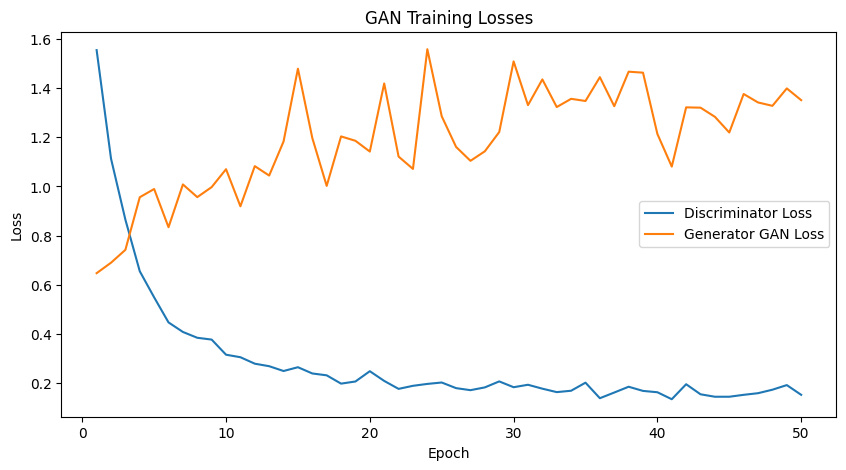

Calculating Perplexity: 100%|██████████| 30/30 [00:14<00:00,  2.10it/s]



Test Perplexity: 76.90

=== Generated Sample Poems ===
--- Sample Poem 1 ---
The next year was a long one for me. I was born in the village of the same name, and lived in a comfortable house, built on the lot of a rich lady, in a village where, after a long and prosperous life, I had to leave behind me the honour of a dear mother. I was married a year later to a man who lived in the town, and in that time, I was very much in love with him. A certain, and very little beautiful, girl

--- Sample Poem 2 ---
There is a great book of essays entitled "The History of the Church in England" which contains a selection of these. It is a beautiful book, and it is worth while to read it.  The first book, the "First Edition," was produced for the "An Introduction to the Poetry of Henry Wadsworth Longfellow," which is probably the first edition to be published in English verse. The second book, the "Second Edition," was produced for the "An Introduction to the Po

--- Sample Poem 3 ---
The Church o

In [ ]:
!pip install transformers datasets torchtext --quiet

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import random
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

from torch.cuda.amp import autocast, GradScaler

DATA_PATH = '/kaggle/input/gutenberg-poetry-dataset/Gutenberg-Poetry.csv'

df = pd.read_csv(DATA_PATH)

poems = df.groupby('gid')['s'].apply(lambda x: ' '.join(x)).reset_index()

print(f"Total poems: {len(poems)}")
print(poems.head())

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'

warnings.filterwarnings(
    'ignore',
    message=r".*decoder-only architecture.*padding_side='left'.*"
)

class PoetryDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=256):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
        }

train_df, temp_df = train_test_split(poems, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

MAX_LENGTH = 256
MAX_NEW_TOKENS = 50
BATCH_SIZE = 4

train_dataset = PoetryDataset(train_df['s'].tolist(), tokenizer, max_length=MAX_LENGTH)
val_dataset = PoetryDataset(val_df['s'].tolist(), tokenizer, max_length=MAX_LENGTH)
test_dataset = PoetryDataset(test_df['s'].tolist(), tokenizer, max_length=MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class Generator(nn.Module):
    def __init__(self, model_name='gpt2'):
        super(Generator, self).__init__()
        self.model = GPT2LMHeadModel.from_pretrained(model_name)
        self.model.resize_token_embeddings(len(tokenizer))
        
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        return outputs

class Discriminator(nn.Module):
    def __init__(self, model_name='gpt2'):
        super(Discriminator, self).__init__()
        self.transformer = GPT2LMHeadModel.from_pretrained(model_name).transformer
        self.discriminator_head = nn.Sequential(
            nn.Linear(self.transformer.config.n_embd, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 1)
        )
        
    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        last_hidden = hidden_states[:, -1, :]
        logits = self.discriminator_head(last_hidden)
        return logits

generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator_optimizer = AdamW(generator.parameters(), lr=5e-5, weight_decay=0.01)
discriminator_optimizer = AdamW(discriminator.parameters(), lr=5e-5, weight_decay=0.01)

from transformers import get_linear_schedule_with_warmup

criterion = nn.BCEWithLogitsLoss()

scaler_gen = GradScaler()
scaler_disc = GradScaler()

def evaluate_generator(generator, val_loader):
    generator.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating Generator"):
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            labels = input_ids.clone()
            with autocast():
                outputs = generator(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    return avg_loss

def train_generator_mle(generator, train_loader, val_loader, optimizer, scheduler, scaler, epoch, patience=3, print_every=50):
    generator.train()
    total_loss = 0
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    early_stop = False
    
    for i, batch in enumerate(tqdm(train_loader, desc=f"Generator MLE Training Epoch {epoch}")):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = input_ids.clone()
        with autocast():
            outputs = generator(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        total_loss += loss.item()
        
        if (i + 1) % print_every == 0:
            avg_loss = total_loss / (i + 1)
            print(f"Epoch {epoch} - Iteration {i+1} - Generator MLE Loss: {avg_loss:.4f}")
    
    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch} - Generator MLE Training Loss: {avg_train_loss:.4f}")
    train_losses.append(avg_train_loss)
    
    val_loss = evaluate_generator(generator, val_loader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch} - Generator MLE Validation Loss: {val_loss:.4f}")
    
    return avg_train_loss, val_loss

def generate_fake_data(generator, num_samples, max_length, batch_size):
    generator.eval()
    fake_texts = []
    with torch.no_grad():
        for _ in tqdm(range((num_samples + batch_size - 1) // batch_size), desc="Generating Fake Data"):
            input_ids = torch.tensor([[tokenizer.bos_token_id]] * batch_size).to(device)
            attention_mask = torch.ones(input_ids.shape).to(device)
            outputs = generator.model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=max_length,
                num_return_sequences=1,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                pad_token_id=tokenizer.eos_token_id
            )
            texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            fake_texts.extend(texts)
    return fake_texts[:num_samples]

def prepare_fake_loader(generator, num_samples, max_length, batch_size):
    fake_texts = generate_fake_data(generator, num_samples, max_length, batch_size)
    fake_dataset = PoetryDataset(fake_texts, tokenizer, max_length=max_length)
    fake_loader = DataLoader(fake_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    return fake_loader

def train_discriminator(discriminator, real_loader, fake_loader, optimizer, scheduler, scaler, epoch, print_every=50):
    discriminator.train()
    total_loss = 0
    for i, (real_batch, fake_batch) in enumerate(zip(real_loader, fake_loader)):
        optimizer.zero_grad()
        
        real_input_ids = real_batch['input_ids'].to(device, non_blocking=True)
        real_attention_mask = real_batch['attention_mask'].to(device, non_blocking=True)
        real_labels = torch.ones((real_input_ids.size(0), 1)).to(device)
        with autocast():
            real_logits = discriminator(real_input_ids, real_attention_mask)
            real_loss = criterion(real_logits, real_labels)
        
        fake_input_ids = fake_batch['input_ids'].to(device, non_blocking=True)
        fake_attention_mask = fake_batch['attention_mask'].to(device, non_blocking=True)
        fake_labels = torch.zeros((fake_input_ids.size(0), 1)).to(device)
        with autocast():
            fake_logits = discriminator(fake_input_ids, fake_attention_mask)
            fake_loss = criterion(fake_logits, fake_labels)
        
        loss = real_loss + fake_loss
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        total_loss += loss.item()
        
        if (i + 1) % print_every == 0:
            avg_loss = total_loss / (i + 1)
            print(f"Epoch {epoch} - Iteration {i+1} - Discriminator Loss: {avg_loss:.4f}")
    
    avg_loss = total_loss / len(real_loader)
    print(f"Epoch {epoch} - Discriminator Loss: {avg_loss:.4f}")
    return avg_loss

def generator_adversarial_loss(generator, discriminator, batch, optimizer, scheduler, scaler):
    generator.train()
    discriminator.eval()
    
    input_ids = batch['input_ids'].to(device, non_blocking=True)
    attention_mask = batch['attention_mask'].to(device, non_blocking=True)
    
    with autocast():
        outputs = generator.model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=MAX_NEW_TOKENS,
            num_return_sequences=1,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.7,
            pad_token_id=tokenizer.eos_token_id
        )
        fake_input_ids = outputs
        fake_attention_mask = (fake_input_ids != tokenizer.pad_token_id).long()
        
        scores = discriminator(fake_input_ids, fake_attention_mask)
        
        labels = torch.ones_like(scores).to(device)
        loss = criterion(scores, labels)
    
    scaler.scale(loss).backward()
    scaler.unscale_(optimizer)
    torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
    scaler.step(optimizer)
    scaler.update()
    scheduler.step()
    
    return loss.item()

def calculate_perplexity(model, dataloader):
    model.eval()
    total_loss = 0
    total_tokens = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Calculating Perplexity"):
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            labels = input_ids.clone()
            with autocast():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
            total_loss += loss.item() * input_ids.size(0)
            total_tokens += input_ids.size(0)
    avg_loss = total_loss / total_tokens
    perplexity = np.exp(avg_loss)
    return perplexity

def generate_sample_poems(generator, num_samples=5, max_length=100):
    generator.eval()
    sample_texts = []
    with torch.no_grad():
        for _ in range(num_samples):
            input_ids = torch.tensor([[tokenizer.bos_token_id]]).to(device)
            attention_mask = torch.ones(input_ids.shape).to(device)
            output = generator.model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=max_length,
                num_return_sequences=1,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=0.7,
                pad_token_id=tokenizer.eos_token_id
            )
            text = tokenizer.decode(output[0], skip_special_tokens=True)
            sample_texts.append(text)
    for i, poem in enumerate(sample_texts, 1):
        print(f"--- Sample Poem {i} ---\n{poem}\n")

EPOCHS_MLE = 25
patience = 3

train_losses = []
val_losses = []
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

total_steps = len(train_loader) * EPOCHS_MLE
scheduler = get_linear_schedule_with_warmup(generator_optimizer,
                                            num_warmup_steps=int(total_steps * 0.1),
                                            num_training_steps=total_steps)

for epoch in range(1, EPOCHS_MLE + 1):
    train_loss, val_loss = train_generator_mle(generator, train_loader, val_loader, generator_optimizer, scheduler, scaler_gen, epoch, patience=patience)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(generator.state_dict(), 'best_generator.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping!")
            break
    torch.cuda.empty_cache()

generator.load_state_dict(torch.load('best_generator.pt'))

plt.figure(figsize=(10,5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.title("Generator MLE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

EPOCHS_GAN = 50
patience = 3

from transformers import get_linear_schedule_with_warmup

total_steps_gan = len(train_loader) * EPOCHS_GAN
gen_scheduler = get_linear_schedule_with_warmup(generator_optimizer,
                                                num_warmup_steps=int(total_steps_gan * 0.1),
                                                num_training_steps=total_steps_gan)
disc_scheduler = get_linear_schedule_with_warmup(discriminator_optimizer,
                                                 num_warmup_steps=int(total_steps_gan * 0.1),
                                                 num_training_steps=total_steps_gan)

discriminator_losses = []
generator_gan_losses = []

for epoch in range(1, EPOCHS_GAN + 1):
    print(f"\n=== GAN Training Epoch {epoch} ===")
    
    fake_loader = prepare_fake_loader(generator, len(train_loader.dataset), MAX_NEW_TOKENS, BATCH_SIZE)
    disc_loss = train_discriminator(discriminator, train_loader, fake_loader, discriminator_optimizer, disc_scheduler, scaler_disc, epoch)
    discriminator_losses.append(disc_loss)
    torch.cuda.empty_cache()
    
    generator_loss = 0
    generator.train()
    for i, batch in enumerate(tqdm(train_loader, desc=f"Generator GAN Training Epoch {epoch}")):
        loss = generator_adversarial_loss(generator, discriminator, batch, generator_optimizer, gen_scheduler, scaler_gen)
        generator_loss += loss
        
        if (i + 1) % 50 == 0:
            avg_gen_loss = generator_loss / (i + 1)
            print(f"Epoch {epoch} - Iteration {i+1} - Generator GAN Loss: {avg_gen_loss:.4f}")
    
    avg_gen_loss = generator_loss / len(train_loader)
    print(f"Epoch {epoch} - Generator GAN Loss: {avg_gen_loss:.4f}")
    generator_gan_losses.append(avg_gen_loss)
    torch.cuda.empty_cache()

plt.figure(figsize=(10,5))
plt.plot(range(1, len(discriminator_losses)+1), discriminator_losses, label='Discriminator Loss')
plt.plot(range(1, len(generator_gan_losses)+1), generator_gan_losses, label='Generator GAN Loss')
plt.title("GAN Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

test_perplexity = calculate_perplexity(generator.model, test_loader)
print(f"\nTest Perplexity: {test_perplexity:.2f}")

print("\n=== Generated Sample Poems ===")
generate_sample_poems(generator, num_samples=5, max_length=100)

os.makedirs('saved_models', exist_ok=True)

generator.model.save_pretrained('saved_models/generator')
tokenizer.save_pretrained('saved_models/generator')

torch.save(discriminator.state_dict(), 'saved_models/discriminator.pth')

print("\nModels saved successfully.")


In [ ]:


import shutil
from IPython.display import FileLink


models_dir = 'saved_models'  


zip_filename = 'saved_models.zip'


shutil.make_archive('saved_models', 'zip', models_dir)

print(f"'{zip_filename}' created successfully!")


'saved_models.zip' created successfully!
